## Customer Success Box : Data Science Internship
<b> Data and Problem Description</b><br>
<p> Predictive modelling for a 'Rare' event in the customer experience journey. This is a customer churn prediction problem with a heavily imbalanced positive class (~1%). The data is in the form of <b>Panel data</b> and has ~60 time-series features for different accounts. Special care needs ot be taken to avoid data leakage across accounts.<br>
     
* <b> Data already Cleaned, Pre-processed </b>, was mentioned on stream that the data doesn't need to be normalised/standardised and all columns seem to be intact, in suitable data types.
</p>

<b>Approach</b>
* <b> Imbalanced Binary Classification - Evaluation Metrics (Precision–Recall, F1 Score)</b><br>
Positive class is extremely scarce (~1%), accuracy can be misleading. The Precision-Recall curve and F1-score used to evaluate models.<br>

1. <b> Naive Method</b> - Feature Selection and Classification Models. Don't exploit time-series, not extracted features from weeks since start of account feature.
 
 * <b> Evaluation - Prioritizing higher Recall </b> since the event is rare and needs intervention, it'll be better to proritize  recall rate even if a lower precision results in more few false positives.
 
 * <b> Dealing with the Imbalance - Weighted cost functions, Resampled data. </b>
 Weighing the models by using inverse frequency of the classes. Undersampling the data resulted in lower performance. SMOTE for oversampled training data.

 * <b> Model/Feature Selection using Multivariate EDA and Recursive Feature Selection</b>
  Split the training data grouped by account ID to avoid leakage.
 
 * <b> Classification Models: </b> Logistic Regression, Random Forest Classifier, XGBoost Classifier etc. all with balanced classs weights. Voting classifer ensemble of models

2. <b>Unsupervised/Anomaly detection approach</b> Isolation forest algorithm.
2.<b> Time-Series based approach </b>- Using time features extracted from date time columns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import math
import warnings

pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import f1_score, classification_report, plot_precision_recall_curve,precision_recall_curve,confusion_matrix, plot_confusion_matrix,precision_recall_fscore_support 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GroupKFold
from itertools import combinations

warnings.filterwarnings("ignore", category=UserWarning)

CPU_CORES = 8

#### Helper Functions 

In [2]:
def overlap_sanity_check(x_train, x_test):
    '''Checks if unique accounts IDs overlap in the sets.
    '''
    for i in x_train.index.unique():
        if i in x_test.index.unique():
            print('Overlap')
            break

In [3]:
def train_test_split_acc(df, test_size = 0.38, verbose=False):
    ''' Splits the DF (includes labels) into Train, validation sets by AccountID.
    Default .38 selected keeps the distribution of the labels similar in both sets.
    '''
    df.sort_index(inplace=True)
    split_acc = df.index.unique()[math.ceil((len(df.index.unique())* test_size))]
    x_train = df.loc[df.index > split_acc]
    x_test = df.loc[df.index <= split_acc]
    y_train = x_train['Label']
    y_test = x_test['Label']
    x_train.drop(['Label'], axis = 1, inplace = True)
    x_test.drop(['Label'], axis = 1, inplace = True)
    if verbose:
        print(f'Split of Labels in train set \n{y_train.value_counts()/len(y_train)}')
    temp_train = x_train.reset_index().account_id
    temp_test = x_test.reset_index().account_id
    if verbose:
        print(f'Number of Accounts in Train {len(temp_train.unique())} \n')
        print(f'Split of Labels in test set \n{y_test.value_counts()/len(y_test)}')
        print(f'Number of Accounts in Train {len(temp_test.unique())}\n')
    overlap_sanity_check(x_train, x_test)
    return x_train, x_test, y_train, y_test

In [4]:
def plot_pr_cuves(clf_list, x, y, title):
    ''' Takes in a list of initialised and fitted classifier instances
    and the DF and labels used for validation.
    save: String for Saving Graph in /Curves
    '''
    fig,ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(12)
    for clf in clf_list:
          plot_precision_recall_curve(clf, x, y, ax = ax)
    #plt.savefig(f'Curves/{title}.jpg')
    plt.title(title)
    plt.show()

# 1. Naive Classification Models 
## A. Baseline Models
1. Baseline Models uisng All Features and balanced weights, plotting Preision-Recall curve on the validation set . Using Random Forest's feature importance for lead on Important Features.
2. So, <b>Baseline Featureset - all features.</b>

| Model| Feature set| 5-Fold CV F1 Score(mean, std)| Validation– Precision, Recall, F1(Optimised Theshold) |
| ---|---|---| ---|
|Random Forest |Baseline features|0.2024, 0.01|0.56      0.44      0.49|
|Logistic Regression|""|0.1724, 0.20|0.46      0.44      0.45|
|XGBoost w/o early stopping |""|0.4870, 0.02| 0.58      0.41      0.48|
|XGBoost w early stopping|""|0.2858, 0.03||
|RF|RFE Feature Set - 8 Feats|0.4925, 0.04|0.58      0.40      0.47|
|LogReg|""|0.3038, 0.23| 0.46      0.42      0.44|
|XGB|""|0.4637, 0.04|0.51      0.45      0.48|
|XGB Early Stopping|""|0.4707, 0.04||
|RF|Feat Set 1 (3)- Corr|0.4742, 0.03|0.47      0.45      0.46|
|LogReg|""|0.2946, 0.22|0.50      0.42      0.46|
|XGB|""|0.4630, 0.03|0.49      0.44      0.46|
|XGB ES|""|0.4677, 0.04|
|XGB|Feat Set 4 (13)|0.2764, 0.09|0.54      0.43      0.48|
|Vote Clf(RF, LogReg, XGB)|""|0.2307, 0.24|0.52      0.43      0.47|
|XGB|Baseline+SMOTE|0.5051, 0.03|0.65      0.31      0.42|

In [5]:
# Data indexed by account ID.
# Data Balance - # 2690 Accounts in train and 713 in test 

train = pd.read_csv('Train_Set.csv', index_col=0)
test = pd.read_csv('Test_Set.csv', index_col=0)

train.Label.value_counts()/len(train), test.Label.value_counts()/len(test)

(0    0.990619
 1    0.009381
 Name: Label, dtype: float64,
 0    0.990648
 1    0.009352
 Name: Label, dtype: float64)

In [6]:
train.head(2)

,week_start_date,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
account_id,,,,,,,,,,,,,,,,,,,,,
100559.0,2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101026.0,2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# [Sparsity] convert columns with 90% zero values to sparse arrays
for col in train.columns[1:]:
    if len(train[train[col] == 0])/len(train) > 0.90:
        train[col] = train[col].astype(pd.SparseDtype(float, fill_value=0.0), copy=True)

In [8]:
# sag solver for logistic regression - requires normalised data, faster for larger datasets.

clf_log = LogisticRegression(max_iter = 300, n_jobs= -1, solver='sag')

clf_rf = RandomForestClassifier(n_estimators=150, criterion='gini',
                                max_depth=6, n_jobs= -1)

xgb_clf = XGBClassifier(max_depth = 6,n_estimators = 100, objective='binary:logistic',
                        learning_rate = .2, eval_metric = 'aucpr',
                       tree_method='gpu_hist')

# saving list of classifiers 
clf_list = [clf_log, clf_rf, xgb_clf]

#### 5-Fold Group CV

In [28]:
def group_cv(model, train, labels, folds, ret_scores= False, normalise=False, class_weights=True):
    """Groups must be AccountId index. For sklearn Models."""
    scores = {'f1_score': [], 'pos_pr': [],
              'pos_rc': [], 'pos_f1': []}

    for train_idx, test_idx in folds.split(train,labels, groups=train.index):
        print(train.iloc[train_idx].shape, train.iloc[test_idx].shape)
        # sanity check 
        #overlap_sanity_check(train.iloc[train_idx], train.iloc[test_idx])

        x_train = train.iloc[train_idx]
        x_test = train.iloc[test_idx]
        
        y_train = labels.iloc[train_idx]
        y_test = labels.iloc[test_idx]
        
        # if normalisation needed for estimator
        if normalise:
            scale = MinMaxScaler()
            x_train = scale.fit_transform(np.array(x_train))
            x_test = scale.transform(np.array(x_test))
        
        # Calculating Class Weights.
        
        model.class_weight = {0:1, 1:1}
        
        if class_weights:
            class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]
            model.class_weight = {0:1, 1:class_weight}
        
        model.fit(x_train, y_train)
        
        preds = model.predict(x_test)
        
        pos_metrics = precision_recall_fscore_support(y_test, preds)
        
        scores['f1_score'].append(f1_score(y_test, preds))       
        scores['pos_pr'].append(pos_metrics[0][1])
        scores['pos_rc'].append(pos_metrics[1][1])
        scores['pos_f1'].append(pos_metrics[2][1])
        
    # score summary
    summary = ((np.mean(np.array(scores['pos_pr'])), np.std(np.array(scores['pos_pr']))),
               (np.mean(np.array(scores['pos_rc'])), np.std(np.array(scores['pos_rc']))),
              (np.mean(np.array(scores['f1_score'])), np.std(np.array(scores['f1_score']))))
    
    if ret_scores:
        return scores
    else:
        return summary

In [69]:
# XGBoost Cross Validation with Early Stopping
def group_cv_xgb(model, train, labels, folds, ret_scores= False, class_weights=False, early_stopping = False):
    """XGboost Classifier trainer with early stopping CV and class weight calc. Due to heavy imbalance square root of class weight
    used for scale pos. weight. Early stopping splits train fold into smaller validation set for early stopping.
    Groups must be AccountId index"""
    scores = {'f1_score': [], 'pos_pr': [],
              'pos_rc': [], 'pos_f1': [],
             'early_stop':[]}

    for train_idx, test_idx in folds.split(train,labels, groups=train.index):
        print(train.iloc[train_idx].shape, train.iloc[test_idx].shape)
        # sanity check 
        #overlap_sanity_check(train.iloc[train_idx], train.iloc[test_idx])

        x_train = train.iloc[train_idx]
        x_test = train.iloc[test_idx]
        
        y_train = labels.iloc[train_idx]
        y_test = labels.iloc[test_idx]
        
        model.scale_pos_weight = 1
        
        # Calculating Class Weights.
        class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]
        
        if class_weights:
            model.scale_pos_weight = np.sqrt(class_weight)
        
        # create a validation set from train split for early stopping
        
        if early_stopping:
            x_train_sm, x_valid, y_train_sm, y_valid = train_test_split_acc(pd.concat((x_train, y_train), axis = 1))
            model.scale_pos_weight = 1
            if class_weights: 
                class_weight = y_train_sm.value_counts()[0]/y_train_sm.value_counts()[1]
                model.scale_pos_weight = np.sqrt(class_weight)
                
            model.fit(x_train_sm, y_train_sm,
                      early_stopping_rounds=5,
                      eval_set=[(x_valid, y_valid)],
                      verbose=False)
            
        elif not early_stopping:
            model.fit(x_train, y_train,
                      verbose=False)
                
        preds = model.predict(x_test)
        
        pos_metrics = precision_recall_fscore_support(y_test, preds)
        
        scores['f1_score'].append(f1_score(y_test, preds))       
        scores['pos_pr'].append(pos_metrics[0][1])
        scores['pos_rc'].append(pos_metrics[1][1])
        scores['pos_f1'].append(pos_metrics[2][1])
        
        if early_stopping:                                                                
            scores['early_stop'].append(model.best_iteration)
                                                                        
    # score summary
    summary = ((np.mean(np.array(scores['pos_pr'])), np.std(np.array(scores['pos_pr']))),
               (np.mean(np.array(scores['pos_rc'])), np.std(np.array(scores['pos_rc']))),
              (np.mean(np.array(scores['f1_score'])), np.std(np.array(scores['f1_score']))),
              (np.mean(np.array(scores['early_stop'])), np.std(np.array(scores['early_stop']))))
    
    if ret_scores:
        return scores
    else:
        return summary

In [45]:
# Group fold on account id to avoid leakage

folds = GroupKFold(n_splits=5)

In [56]:
group_cv(clf_rf, train.drop(['Label', 'week_start_date'], axis = 1), train['Label'], folds)

(91764, 62) (22942, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)


((0.14769662745205397, 0.035802926952787466),
 (0.5450311835685412, 0.036497660447198016),
 (0.2293116772237215, 0.03840627996188621))

In [27]:
# Logistic Regression 5 Fold CV
group_cv(clf_log, train.drop(['Label', 'week_start_date'], axis = 1), train['Label'], folds, normalise=True)

(91764, 62) (22942, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)


((0.47247999729990414, 0.23588322962999686),
 (0.48655908927078195, 0.24134787959887175),
 (0.3653599223723123, 0.17853064859077794))

In [57]:
# XGBoost without early stopping
group_cv_xgb(xgb_clf, train.drop(['Label', 'week_start_date'], axis = 1), train['Label'], folds,class_weights=False, early_stopping=False)

(91764, 62) (22942, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)


/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


((0.7204723762506531, 0.05056369245948564),
 (0.3686385076507491, 0.02298374966013342),
 (0.48700262243337694, 0.025513164877988156),
 (nan, nan))

In [58]:
# XGBoost without early stopping and class weights
group_cv_xgb(xgb_clf, train.drop(['Label', 'week_start_date'], axis = 1), train['Label'], folds,class_weights=True, early_stopping=False)

(91764, 62) (22942, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)


/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


((0.5895806354689451, 0.06023126413046813),
 (0.4516027910561469, 0.028671357184557628),
 (0.5093012006065423, 0.024697094278632023),
 (nan, nan))

In [59]:
# XGBoost with early stopping and without calss weights
group_cv_xgb(xgb_clf, train.drop(['Label', 'week_start_date'], axis = 1), train['Label'], folds,class_weights=False, early_stopping=True)

(91764, 62) (22942, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)


((0.6851383408511168, 0.0547162909757846),
 (0.37957663573239764, 0.0277621019365243),
 (0.4869946863341708, 0.026652210858398466),
 (18.4, 7.2))

In [60]:
# XGBoost with early stopping and class weights
group_cv_xgb(xgb_clf, train.drop(['Label', 'week_start_date'], axis = 1), train['Label'], folds,class_weights=True, early_stopping=True)

(91764, 62) (22942, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)


((0.6237596099429716, 0.05900059739227057),
 (0.45858918479475685, 0.029721903664973286),
 (0.5272331739699851, 0.03345031282889092),
 (16.6, 6.6211781428987395))

#### Validation Set Metrics
Both recall and accuracy are low,will try feature selection and optimising the hyperparameters classifiers.

In [9]:
# Data balance on split train, validation sets. - This gives 1666 accounts in train and 1024 accounts in validation.
x_train, x_test, y_train, y_test = train_test_split_acc(train, test_size=0.38)

# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)
# Saving baseline feature set 
baseline_features = x_train.columns.to_list()

In [68]:
#scale = StandardScaler()
scale = MinMaxScaler()
x_train_scale = scale.fit_transform(x_train)
x_test_scale = scale.transform(x_test)

In [10]:
# Calculating Class Weights.
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [70]:
clf_log.fit(x_train_scale, y_train)
clf_rf.fit(x_train_scale, y_train)
xgb_clf.fit(x_train_scale, y_train, verbose=True)

clf_log.class_weight = {0:1, 1:class_weight}
clf_rf.class_weight = {0:1, 1:class_weight}
xgb_clf.scale_pos_weight = np.sqrt(class_weight)

print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train_scale)))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train_scale)))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train_scale)))}')

Logistic Regression - 0.40834248079034025
Random Forest - 0.31012145748987857
XGBoost - 0.6236162361623616


### Moving threshold to find Optimal Threshold

In [87]:
def return_threshold(clf, X, y):
    """Returns threshold that maximises the F1 Score.
    Only supports estimators that have a predict_proba method."""
    
    probs = clf.predict_proba(X)
    # keep probabilities for the positive outcome only
    probs = probs[:,1]
    
    precision, recall, thresholds = precision_recall_curve(y_true=y, probas_pred=probs)
    
    # manually calculate the F1 score and find the index of argmax of F1 score. 
    # use that index to find max threshold.
    f_score = (2 * precision * recall) / (precision + recall)

    ix = np.argmax(f_score)
    threshold = thresholds[ix]
    print(threshold)
    return threshold

In [88]:
# Now filtering predictions using this threshold and classification report and confusion matrix

def preds_threhold(model, threshold, X):
    probs = model.predict_proba(X)
    y_preds = (probs[:,1] >=threshold).astype('int')    
    return y_preds

In [73]:
rf_trx = return_threshold(clf_rf, x_train_scale, y_train)
log_trx = return_threshold(clf_log, x_train_scale, y_train)
xgb_trx = return_threshold(xgb_clf, x_train_scale, y_train)

y_pred_rf = preds_threhold(clf_rf, rf_trx, x_test_scale)
y_pred_log = preds_threhold(clf_log, log_trx, x_test_scale)
y_pred_xgb = preds_threhold(xgb_clf, xgb_trx, x_test_scale)

print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

0.6866113477853654
1.6355110541387047e-15
0.39447662
Logistic Regression
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.48      0.44      0.46       448

    accuracy                           0.99     47582
   macro avg       0.74      0.72      0.73     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.62      0.35      0.45       448

    accuracy                           0.99     47582
   macro avg       0.81      0.68      0.72     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.52      0.43      0.47       448

    accuracy                           0.99     47582
   macro avg   

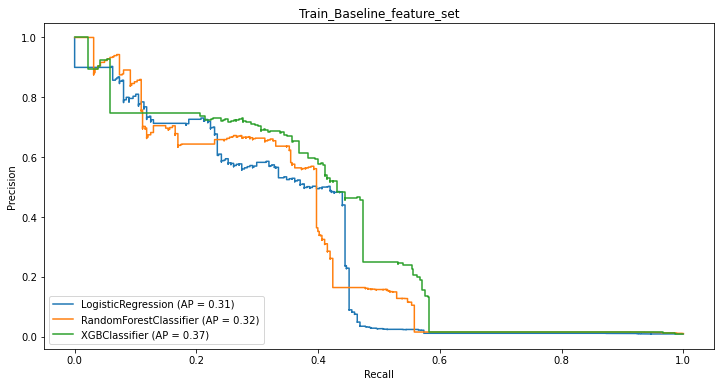

In [74]:
plot_pr_cuves(clf_list, x_test_scale, y_test,title = 'Train_Baseline_feature_set')

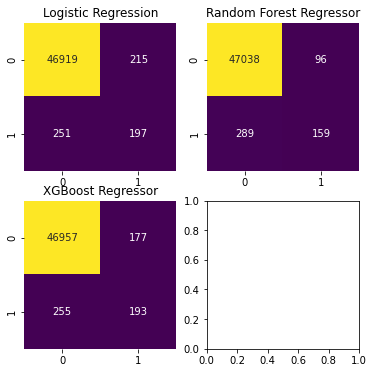

In [75]:
# Using Optimal threshold higher precision, lower recall
# we can give more weightage to recall. Upto the business problem.

fig, ax = plt.subplots(2, 2, figsize=(6,6))

sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, cmap="viridis",fmt='d',cbar=False, ax = ax[0][0])
ax[0][0].set_title('Logistic Regression')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, cmap="viridis",fmt='d',cbar=False, ax = ax[0][1])
ax[0][1].set_title('Random Forest Regressor')

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, cmap="viridis",fmt='d',cbar=False, ax = ax[1][0])
ax[1][0].set_title('XGBoost Regressor')

plt.show()

In [27]:
## Get feature importance from RF
feat_imp = pd.DataFrame(index=baseline_features , data = clf_rf.feature_importances_, columns=['Feature_Importance'])
feat_imp.sort_values(by = 'Feature_Importance', axis = 0, ascending=False, inplace = True)
imp_features = feat_imp.index.to_list()[:10]
feat_imp[:10]

,Feature_Importance
feature15,0.262112
feature37,0.131756
feature16,0.086761
feature12,0.065765
feature19,0.051564
feature47,0.051497
feature18,0.046491
feature22,0.039969
feature21,0.036750
feature53,0.034995


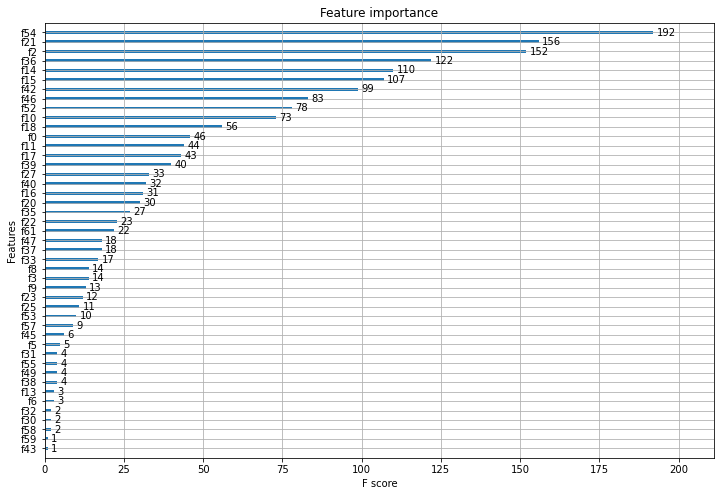

In [96]:
# Actual feature : feature number +1 
plt.rcParams['figure.figsize'] = [12, 8]
plot_importance(xgb_clf,height=0.3, importance_type='weight')
plt.show()

## B. Recursive Feature Selection 
From Random Forest Classifier and XGBoost Classifer, find the 7-8 most mportant Features. Using RFE to check which are the most useful features. RFE is a greedy technique that uses the coefficients of linear models or the impurity decrease metric of tree based classifiers to reursively build and test models while removing the least useful features at each stage. 

In [97]:
feat_sel = RFE(XGBClassifier(scale_pos_weight = np.sqrt(class_weight), max_depth = 6, n_estimators = 100, objective='binary:logistic',
                             learning_rate = .2, eval_metric = 'aucpr', tree_method='gpu_hist'),
               n_features_to_select=8, step=8, verbose=1)

feat_sel.fit(np.array(x_train_scale), y_train)

Fitting estimator with 62 features.
Fitting estimator with 54 features.
Fitting estimator with 46 features.
Fitting estimator with 38 features.
Fitting estimator with 30 features.
Fitting estimator with 22 features.
Fitting estimator with 14 features.


RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, eval_metric='aucpr',
                            gamma=None, gpu_id=None, importance_type='gain',
                            interaction_constraints=None, learning_rate=0.2,
                            max_delta_step=None, max_depth=6,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=10.290060753876594, subsample=None,
                            tree_method='gpu_hist', validate_parameters=None,
                            verbosity=None),
    n_features_to_select=8, step=8, verbose=1)

In [98]:
# Selected features
pd.DataFrame(data = feat_sel.ranking_, index = baseline_features).sort_values(by = 0, ascending = True).head(10)

,0
feature37,1
feature40,1
feature6,1
feature54,1
feature16,1
feature15,1
feature11,1
feature12,1
feature46,2
feature36,2


In [16]:
rfe_feats = ['feature12', 'feature37', 'feature40','feature21','feature46',
             'feature54', 'feature16', 'feature15']

group_cv_xgb(xgb_clf, train[rfe_feats], train['Label'], folds, class_weights=True, early_stopping=True)

(91764, 8) (22942, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)


((0.5359553289746684, 0.06799834828255477),
 (0.47782493510817703, 0.029820628491843363),
 (0.5038039847526175, 0.04123398118163879),
 (12.4, 3.3823069050575527))

In [102]:
group_cv(clf_rf, train[rfe_feats], train['Label'], folds, normalise=True)

(91764, 8) (22942, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)


((0.49007488703254093, 0.05064096524494156),
 (0.5025855885433766, 0.02924212565833669),
 (0.4954018562833863, 0.0368266567696211))

In [103]:
group_cv(clf_log, train[rfe_feats], train['Label'], folds, normalise=True)

(91764, 8) (22942, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)
(91765, 8) (22941, 8)


((0.3656962478162403, 0.29500176644734094),
 (0.6210942288848578, 0.293655735810697),
 (0.28543823390815243, 0.21878869615166846))

In [105]:
x_train_rfe = scale.fit_transform(np.array(x_train[rfe_feats]))
x_test_rfe = scale.transform(np.array(x_test[rfe_feats]))

xgb_clf.fit(x_train_rfe, y_train, verbose=True)

clf_log.fit(x_train_rfe, y_train)
clf_rf.fit(x_train_rfe, y_train)

print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(x_train_rfe))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(x_train_rfe))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(x_train_rfe))}')

Logistic Regression - 0.5325638911788954
Random Forest - 0.546448087431694
XGBoost - 0.5924006908462867


In [106]:
rf_trx = return_threshold(clf_rf, x_train_rfe, y_train)
log_trx = return_threshold(clf_log, x_train_rfe, y_train)
xgb_trx = return_threshold(xgb_clf, x_train_rfe, y_train)

y_pred_rf = preds_threhold(clf_rf, rf_trx, x_test_rfe)
y_pred_log = preds_threhold(clf_log, log_trx, x_test_rfe)
y_pred_xgb = preds_threhold(xgb_clf, xgb_trx, x_test_rfe)

print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

0.7762533656787696
0.9999680229780946
0.5295063
Logistic Regression
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     47134
         1.0       0.47      0.43      0.45       448

    accuracy                           0.99     47582
   macro avg       0.73      0.71      0.72     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.58      0.38      0.46       448

    accuracy                           0.99     47582
   macro avg       0.79      0.69      0.73     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.54      0.44      0.49       448

    accuracy                           0.99     47582
   macro avg       0

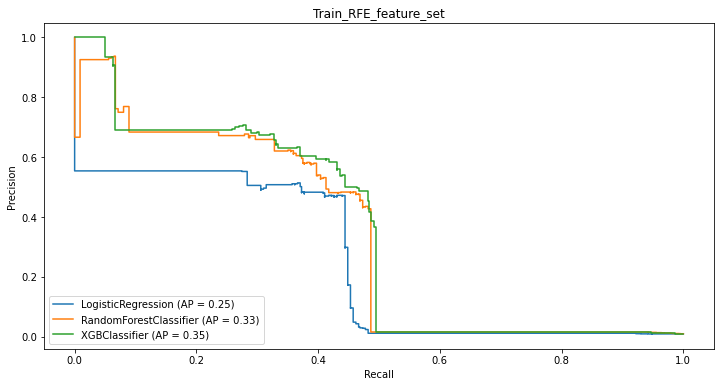

In [107]:
plot_pr_cuves(clf_list, x_test_rfe, y_test,title = 'Train_RFE_feature_set')

## C. Multivariate EDA, Data Interaction and Manual Feature Selection

### Perason's Correlation Between Features 
1. Finding and plotting the features with highest absolute correlations between them, along with the positive labels in yellow. 
2. The most correlated features don't seem to have much discriminating power, most likely adding noise,  can be ignored.

In [30]:
## Getting the highest absolute correlations between features. Get pair of features, find correlations for each pair,
# store in list along with feature names

temp = train.drop(['Label', 'week_start_date'] , axis = 1).copy()
temp_corr = temp.corr()

corr_list = []
pair_feat = []
# Reduced complexity from two nested for loops uisng itertools combinations.
for i, item in enumerate(list(combinations(temp.columns.to_list(),2))):
    pair_feat.append(item)
    
for item in pair_feat:
    corr_list.append([item[0], item[1], np.abs(temp_corr.at[item[0], item[1]])])

corr_array = np.array(corr_list)
corr_array = corr_array[corr_array[:,2].argsort()][::-1]
#corr_array[104:124]

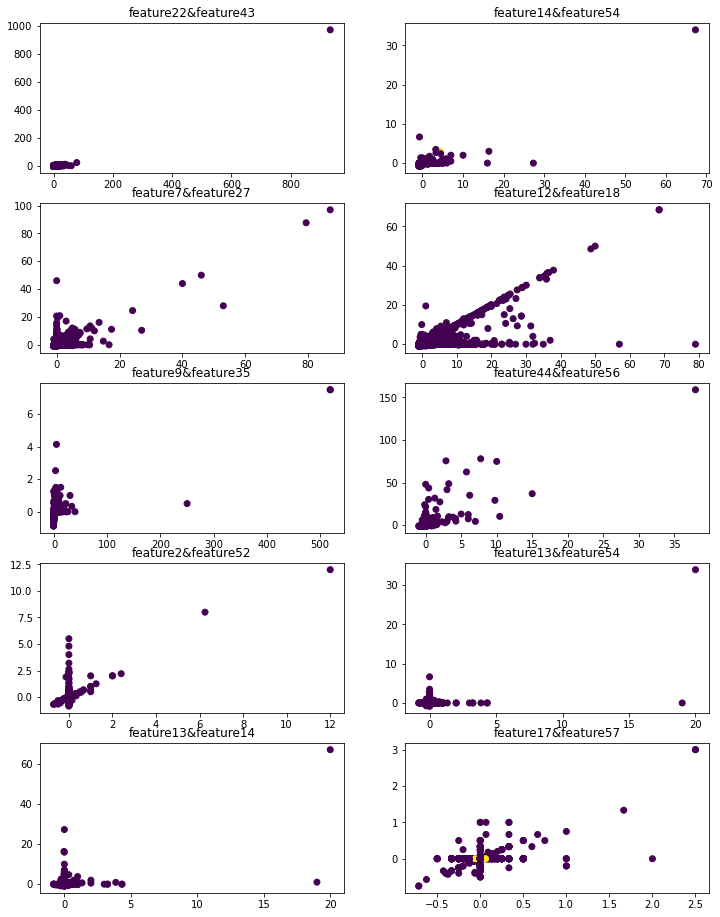

In [36]:
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(12)
for i, item in enumerate(corr_array[104:114]):
    ax = fig.add_subplot(5, 2, i+1)
    plt.scatter(x = train[item[0]].values, y = train[item[1]].values, c = train.Label.values)
    ax.set_title(item[0] + '&' + item[1])

### Pearson's correlation of features with Label 
1. Although the pearson's correlation for the continuous variables and categorical target is not strictly meaningful, in practise it can be useful. <br> 
2. The skew can also affect the correlation, checked later with the majority class undersampled. Tried to model with undersampled data but resulted in worse performance than weighted cost.
3. Features 15, 16, 37 seem to be highly correlated with the label.<br>
<b>Feature Set 1 (3 features with highest Correlation with label)</b>

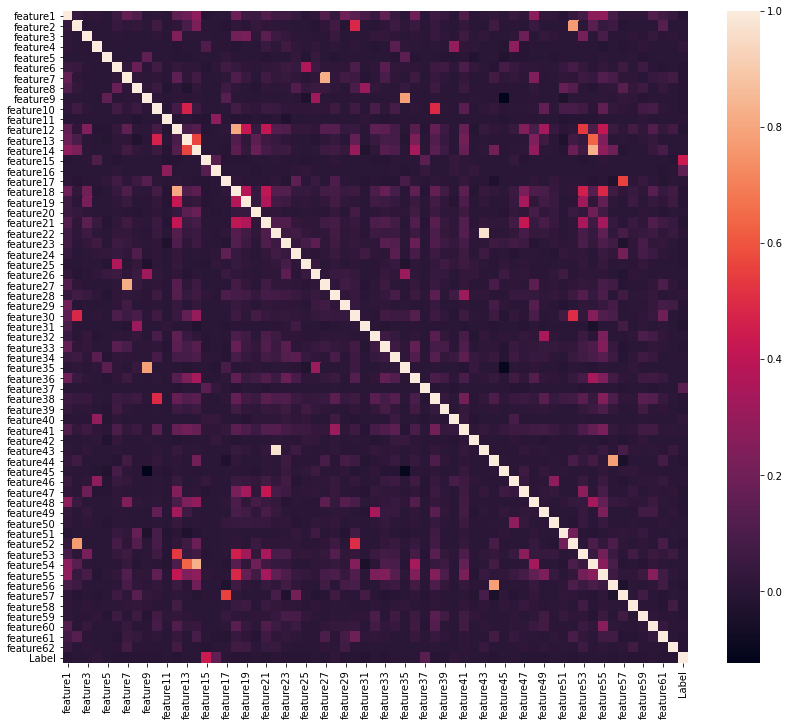

In [31]:
temp = train.copy()
#temp.drop(['Label'], axis =1, inplace = True)
plt.figure(figsize=(14,12))
sns.heatmap(temp.corr(method='pearson'))
plt.show()

In [32]:
label_corr = temp.drop(['Label'], axis = 1).corrwith(temp['Label'])
label_corr = label_corr.apply(lambda x: np.abs(x))
label_corr.sort_values(ascending=False)[:10]

feature15    0.434853
feature16    0.149382
feature37    0.138772
feature40    0.024171
feature4     0.021444
feature31    0.015772
feature28    0.013807
feature41    0.009900
feature17    0.007916
feature12    0.006892
dtype: float64

### Randomly Undersampling Majority Class and then checking correlation with label
1. This method is not robust as we're throwing away a lot of data. We can see that as values for certain features  in the sample are just 0, shows up as no correlation with any other features below.
2. The features that appear to be correlated with the labels for this sample are the ones selected from the multivariate EDA below. Those assumptions seems to have been correct.
3. Modelled using undersampled data, lower performance than using all data, graph saved in Curves folder, suffixed undersamplped.

In [33]:
temp = train.copy()
# shuffling the train set before 
temp = temp.sample(frac = 1, random_state = 15)
# getting the same number of samples for majority class, 1076
intervene = temp.loc[temp['Label'] == 1]
no_intervene = temp.loc[temp['Label'] == 0].iloc[:1076]
new_df = pd.concat([intervene, no_intervene ])
# shuffling this new df
new_df = new_df.sample(frac=1)
new_df.Label.value_counts()

1.0    1076
0.0    1076
Name: Label, dtype: int64

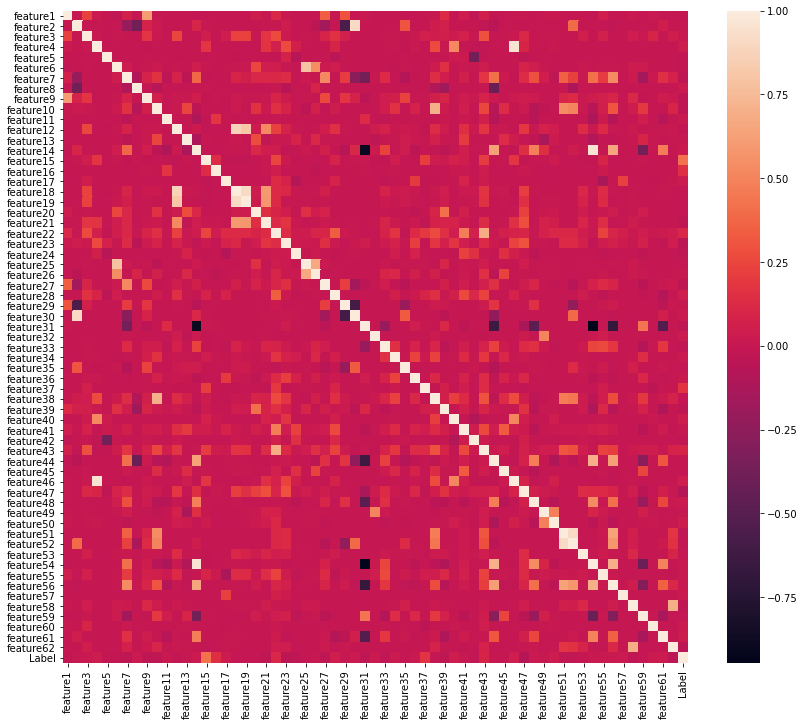

In [34]:
# Now correlations for this balanced subsample. 
plt.figure(figsize=(14,12))
sns.heatmap(new_df.corr(method = 'pearson'))
plt.show()

In [35]:
label_corr = new_df.drop(['Label'], axis = 1).corrwith(new_df['Label'])
label_corr = label_corr.apply(lambda x: np.abs(x))
label_corr.sort_values(ascending=False)[:10]

feature15    0.416622
feature37    0.170694
feature16    0.146394
feature22    0.106429
feature43    0.089432
feature47    0.077155
feature28    0.053332
feature46    0.045846
feature62    0.044847
feature4     0.042295
dtype: float64

### Data Interaction of features correlated with label.
1. The yellow points are positive classes where intervention was required.
2. There is definitely interesting interaction between these features, there is clear distinction between the postive classes in the graphs on the first column.
3. Comparing these plots with the interaction of multiple accounts with features from the livestream, it appears to be that these features cross each other just around the min threshold.
4. These features don't seem to be highly correlated.
2. Interestingly, the useful features are the ones whose interaction have a distinct cross like interaction. The labels turning to 1 somewhat depends on the points being on the outside of the interaction of the points. Can be result of PCA transformation.

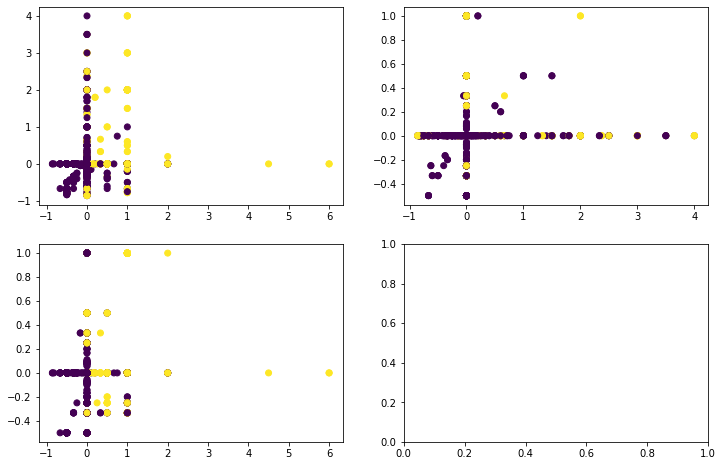

In [40]:
# Correlation of 0.125
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0,0].scatter(x = train['feature15'].values, y = train['feature16'].values, c = train.Label.values)
# Correlation of 0.0310
ax[0,1].scatter(x = train['feature16'].values, y = train['feature37'].values, c = train.Label.values)
# Correlation of 0.141
ax[1,0].scatter(x = train['feature15'].values, y = train['feature37'].values, c = train.Label.values)
plt.show()

![](multiple_accounts_single_features.png)

## D. Models using only the features most correlated with the label
1. Similar recall to previous model, much improved precision, the curve is also much more stable across the board.

In [18]:
feature_set_1 = ['feature15', 'feature16', 'feature37']
x_train_feat_1 = scale.fit_transform(np.array(x_train[feature_set_1]))
x_test_feat_1 = scale.transform(np.array(x_test[feature_set_1]))

In [113]:
group_cv_xgb(xgb_clf, train[feature_set_1], train['Label'], folds, class_weights=True, early_stopping=True)

(91764, 3) (22942, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)


((0.4931780605483581, 0.058506217409271574),
 (0.4893567581933981, 0.023352845632586213),
 (0.49039190267735455, 0.03899364962307424),
 (12.0, 1.6733200530681511))

In [114]:
group_cv(clf_rf, train[feature_set_1], train['Label'], folds, normalise=False)

(91764, 3) (22942, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)


((0.44744219185718404, 0.055230482724490465),
 (0.5137967258098115, 0.023280610278778303),
 (0.4774573993664693, 0.04006228310049016))

In [115]:
group_cv(clf_log, train[feature_set_1], train['Label'], folds, normalise=True)

(91764, 3) (22942, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)
(91765, 3) (22941, 3)


((0.3092551614141881, 0.3812542708085698),
 (0.688148374207893, 0.3647362461522809),
 (0.1459178733055114, 0.18322995822625546))

In [116]:
clf_log.fit(x_train_feat_1, y_train)
clf_rf.fit(x_train_feat_1, y_train)
xgb_clf.fit(x_train_feat_1, y_train, verbose=True)

print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(x_train_feat_1))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(x_train_feat_1))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(x_train_feat_1))}')

rf_trx = return_threshold(clf_rf, x_train_feat_1, y_train)
log_trx = return_threshold(clf_log, x_train_feat_1, y_train)
xgb_trx = return_threshold(xgb_clf, x_train_feat_1, y_train)

y_pred_rf = preds_threhold(clf_rf, rf_trx, x_test_feat_1)
y_pred_log = preds_threhold(clf_log, log_trx, x_test_feat_1)
y_pred_xgb = preds_threhold(xgb_clf, xgb_trx, x_test_feat_1)

print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression - 0.5352348993288591
Random Forest - 0.5414364640883977
XGBoost - 0.5418006430868167
0.7688562469637295
0.9982629867059862
0.78995574
Logistic Regression
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     47134
         1.0       0.46      0.43      0.44       448

    accuracy                           0.99     47582
   macro avg       0.73      0.71      0.72     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.50      0.43      0.46       448

    accuracy                           0.99     47582
   macro avg       0.75      0.71      0.73     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.49

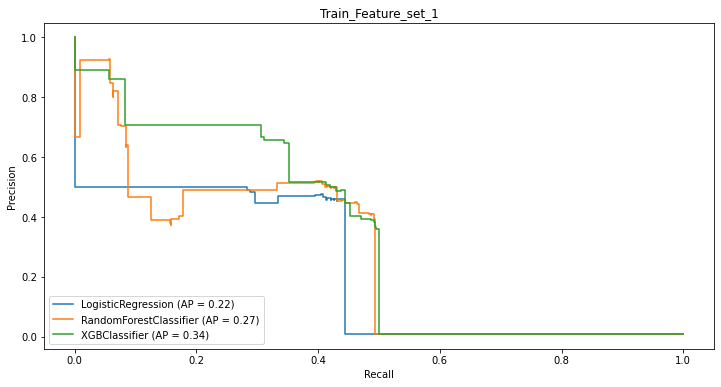

In [117]:
plot_pr_cuves(clf_list, x_test_feat_1, y_test,title = 'Train_Feature_set_1')

### Plotting Important features from baseline Random Forest 
1. Interactions of other features shows similar behaviour to the features selected so far, this interaction of the data seems important.
2. Creating Feature set 2 by combining a few promising features from these interactions and featureset1. 
3. <b>Featureset 2 (7 features). </b> Modelling.
4. Recall increased slightly.

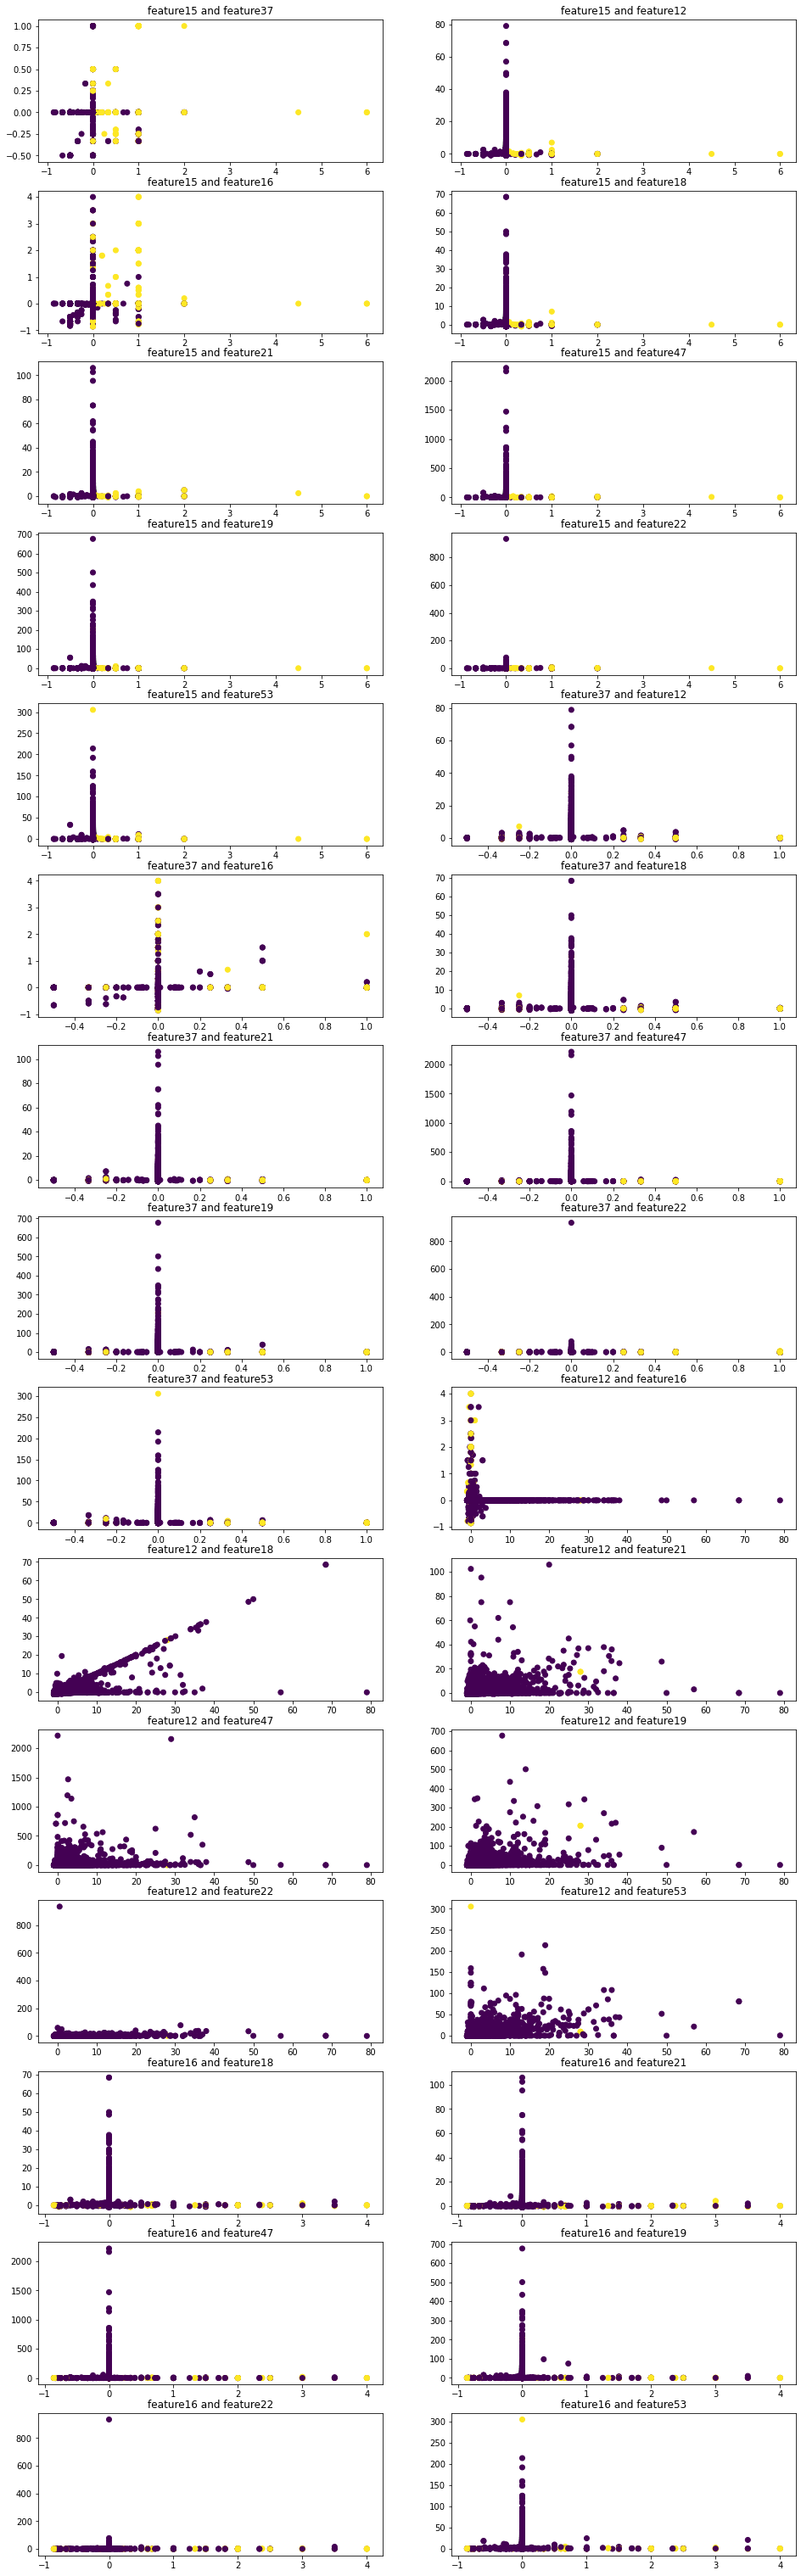

In [67]:
combinations_imp = list(combinations(imp_features, 2))
fig = plt.figure(figsize=(16, 55))
for i, item in enumerate(combinations_imp[:30]):
    ax = fig.add_subplot(15, 2, i+1)
    ax.scatter(x = train[item[0]].values, y = train[item[1]].values, c = train.Label.values)
    ax.title.set_text(f'{item[0]} and {item[1]}')
    
plt.show()

In [19]:
feature_set_2 = ['feature15', 'feature16', 'feature37','feature55',
                 'feature12', 'feature18', 'feature47']

x_train_feat_2 = scale.fit_transform(np.array(x_train[feature_set_2]))
x_test_feat_2 = scale.transform(np.array(x_test[feature_set_2]))

In [123]:
group_cv_xgb(xgb_clf, train[feature_set_2], train['Label'], folds, class_weights=True, early_stopping=True)

(91764, 7) (22942, 7)
(91765, 7) (22941, 7)
(91765, 7) (22941, 7)
(91765, 7) (22941, 7)
(91765, 7) (22941, 7)


((0.5788603382533228, 0.07217212613985176),
 (0.470338893980515, 0.02952945643765067),
 (0.5175008704302815, 0.04341441390339017),
 (16.0, 5.865151319446072))

In [124]:
clf_log.fit(x_train_feat_2, y_train)
clf_rf.fit(x_train_feat_2, y_train)
xgb_clf.fit(x_train_feat_2, y_train,verbose=True)

print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(x_train_feat_2))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(x_train_feat_2))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(x_train_feat_2))}')
rf_trx = return_threshold(clf_rf, x_train_feat_2, y_train)
log_trx = return_threshold(clf_log, x_train_feat_2, y_train)
xgb_trx = return_threshold(xgb_clf, x_train_feat_2, y_train)

y_pred_rf = preds_threhold(clf_rf, rf_trx, x_test_feat_2)
y_pred_log = preds_threhold(clf_log, log_trx, x_test_feat_2)
y_pred_xgb = preds_threhold(xgb_clf, xgb_trx, x_test_feat_2)

print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression - 0.1846590909090909
Random Forest - 0.3519230769230769
XGBoost - 0.6069829901521934
0.8291945172824099
1.8522567195985747e-14
0.6446253
Logistic Regression
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     47134
         1.0       0.47      0.45      0.46       448

    accuracy                           0.99     47582
   macro avg       0.73      0.72      0.73     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.61      0.35      0.45       448

    accuracy                           0.99     47582
   macro avg       0.80      0.68      0.72     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0

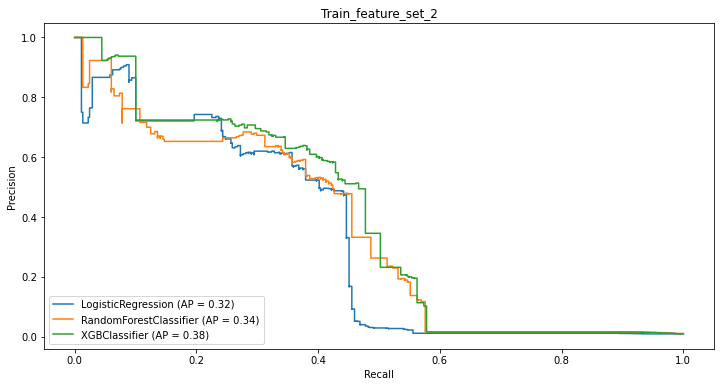

In [125]:
plot_pr_cuves(clf_list,x_test_feat_2, y_test,title = 'Train_feature_set_2')

### C. Features with non-zero value and the largest counts of corresponding positive examples.
1. These features could have good discriminating power.
3. Featureset_3 (6 of the features with the largest count of positive examples), modelling.

In [50]:
for item in train.columns:
    try:
        print(item, train.loc[train[item]!= 0].Label.value_counts()[1])
    except KeyError:
        pass

week_start_date 1076
feature1 18
feature3 215
feature4 9
feature6 2
feature7 8
feature9 8
feature10 8
feature11 36
feature12 83
feature14 4
feature15 406
feature16 105
feature17 10
feature18 75
feature19 66
feature21 70
feature22 299
feature23 40
feature24 5
feature26 5
feature27 4
feature28 47
feature31 2
feature32 9
feature33 5
feature34 23
feature36 17
feature37 209
feature38 13
feature39 10
feature40 10
feature41 61
feature43 262
feature44 4
feature45 1
feature46 15
feature47 99
feature48 6
feature49 7
feature50 8
feature53 129
feature54 4
feature55 273
feature56 4
feature57 1
feature58 12
feature59 2
feature60 10
feature61 2
feature62 24
Label 1076


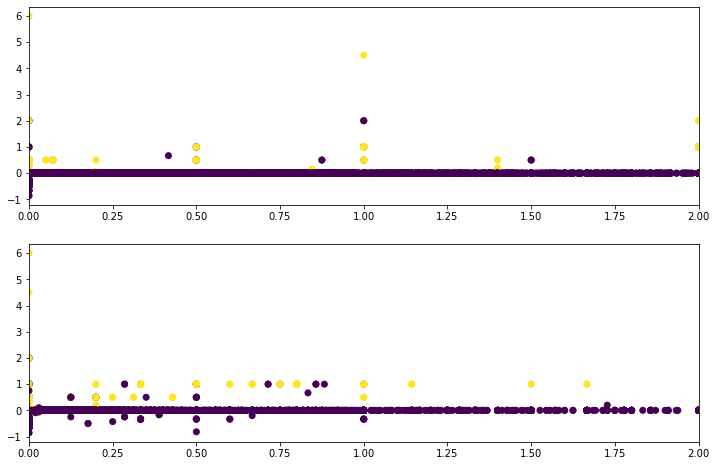

In [51]:
# try checking with 43, 3, 37 
fig, ax = plt.subplots(2, 1)
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0].set_xlim(0,2)
ax[0].scatter(x = train['feature22'].values, y = train['feature15'].values, c = train.Label.values)
ax[1].set_xlim(0,2)
ax[1].scatter(x = train['feature55'].values, y = train['feature15'].values, c = train.Label.values)
plt.show()

In [20]:
feature_set_3 = ['feature15', 'feature22', 'feature55', 'feature43', 'feature3', 'feature37']


x_train_feat_3 = scale.fit_transform(np.array(x_train[feature_set_3]))
x_test_feat_3 = scale.transform(np.array(x_test[feature_set_3]))

group_cv_xgb(xgb_clf, train[feature_set_3], train['Label'], folds, class_weights=True, early_stopping=True)

In [128]:
clf_log.fit(x_train_feat_3, y_train)
clf_rf.fit(x_train_feat_3, y_train)
xgb_clf.fit(x_train_feat_3, y_train, 
             verbose=True)

print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(x_train_feat_3))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(x_train_feat_3))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(x_train_feat_3))}')
rf_trx = return_threshold(clf_rf, x_train_feat_3, y_train)
log_trx = return_threshold(clf_log, x_train_feat_3, y_train)
xgb_trx = return_threshold(xgb_clf, x_train_feat_3, y_train)

y_pred_rf = preds_threhold(clf_rf, rf_trx, x_test_feat_3)
y_pred_log = preds_threhold(clf_log, log_trx, x_test_feat_3)
y_pred_xgb = preds_threhold(xgb_clf, xgb_trx, x_test_feat_3)

print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression - 0.4454756380510441
Random Forest - 0.32732447817836813
XGBoost - 0.5941747572815534
0.794667378277577
3.3917640355972727e-16
0.58785164
Logistic Regression
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.47      0.42      0.44       448

    accuracy                           0.99     47582
   macro avg       0.73      0.71      0.72     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.59      0.33      0.42       448

    accuracy                           0.99     47582
   macro avg       0.79      0.67      0.71     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       

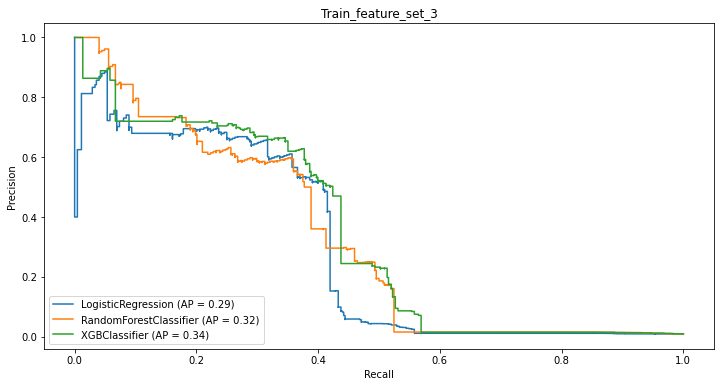

In [129]:
plot_pr_cuves(clf_list, x_test_feat_3, y_test,title = 'Train_feature_set_3')

## E. Combining Features Selected till now
1. Featureset 4, 13 selected features.
2. Also Adding a voting classifier ensemble classifier.
3. Similar performance to feature_set_2, slighlty higher precision in upper range of recall.

In [21]:
feature_set_4  = ['feature15','feature37','feature55','feature47','feature18','feature12',
                 'feature19','feature21','feature43','feature16','feature53','feature3','feature22']

In [131]:
vote_clf = VotingClassifier([('log_reg', clf_log), ('rf_clf', clf_rf), ('xgb_clf', xgb_clf)]
                            , voting='soft', n_jobs=-1)

clf_list = [clf_log, clf_rf, xgb_clf, vote_clf]

scale = MinMaxScaler()

x_train_scale = scale.fit_transform(x_train[feature_set_4])
x_test_scale = scale.transform(x_test[feature_set_4])

group_cv_xgb(xgb_clf, train[feature_set_4], train['Label'], folds, class_weights=True, early_stopping=True)

(91764, 13) (22942, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)


((0.5748776281022275, 0.09418234992223189),
 (0.4620400806040316, 0.023150228697609364),
 (0.5095746458892576, 0.0479847810675771),
 (12.2, 8.034923770640265))

In [132]:
group_cv(vote_clf, train[feature_set_4], train['Label'], folds, normalise=True)

(91764, 13) (22942, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)


((0.181589350888576, 0.08621533694868191),
 (0.5498038954953264, 0.026991462000826864),
 (0.26115199492974533, 0.08816535814349401))

In [133]:
clf_log.fit(x_train_scale, y_train)
clf_rf.fit(x_train_scale, y_train)
xgb_clf.fit(x_train_scale, y_train, 
             verbose=True)

vote_clf.fit(x_train_scale, y_train)

print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(x_train_scale))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(x_train_scale))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(x_train_scale))}')
print(f'VotingClassifier - {f1_score(y_train, vote_clf.predict(x_train_scale))}')

rf_trx = return_threshold(clf_rf, x_train_scale, y_train)
log_trx = return_threshold(clf_log, x_train_scale, y_train)
xgb_trx = return_threshold(xgb_clf, x_train_scale, y_train)
vote_trx = return_threshold(vote_clf, x_train_scale, y_train)

y_pred_rf = preds_threhold(clf_rf, rf_trx, x_test_scale)
y_pred_log = preds_threhold(clf_log, log_trx, x_test_scale)
y_pred_xgb = preds_threhold(xgb_clf, xgb_trx, x_test_scale)
y_pred_vote = preds_threhold(vote_clf, vote_trx, x_test_scale)

print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))
print('Voting Classifier\n',classification_report(y_test, y_pred_vote))

Logistic Regression - 0.018345603639193152
Random Forest - 0.35156615240766714
XGBoost - 0.6176470588235294
VotingClassifier - 0.5874001774622893
0.7568027544455406
0.9988841189664855
0.47707477
0.3598018753717244
Logistic Regression
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.48      0.43      0.45       448

    accuracy                           0.99     47582
   macro avg       0.73      0.71      0.72     47582
weighted avg       0.99      0.99      0.99     47582

RandomForestClassifier
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.59      0.36      0.44       448

    accuracy                           0.99     47582
   macro avg       0.79      0.68      0.72     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

         0.0     

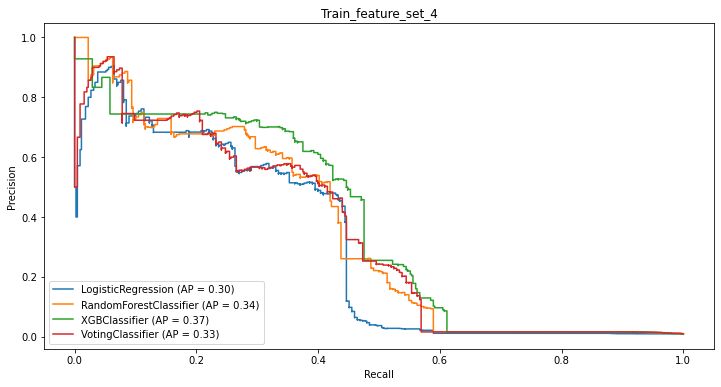

In [134]:
plot_pr_cuves(clf_list, x_test_scale, y_test,title = 'Train_feature_set_4')

## F. Final Precision-Recall Curves on provided test set Using Naive Approach
1. Training the models on entire training data.
2. Predicting for test data, only using labels for the evaluation.
3. XGBoost with all the features still appears to slighlty outperform the models when trained with featureset4, still that's a reduction of the used features from 62 to 13. Clearly these features are important for the classification.
4. Hyperparameter optimization next, other techniques, feature selection done for the most part.

In [70]:
# Change the featureset before and fit on new featureset before plotting curve.
#featureset = baseline_features
featureset = rfe_feats

In [71]:
x_train = train[featureset]
y_train = train['Label']
x_test = test[featureset]
y_test = test['Label']

In [72]:
scale = MinMaxScaler()

x_train_scale = scale.fit_transform(x_train[featureset])
x_test_scale = scale.transform(x_test[featureset])

clf_log.fit(x_train_scale, y_train)
clf_rf.fit(x_train_scale, y_train)
xgb_clf.fit(x_train_scale, y_train)
# Set according to featureset and early stopping, letting model overfit slightly
xgb_clf.n_estimators = 300
xgb_clf.learning_rate = 0.5

vote_clf.fit(x_train_scale, y_train)

clf_list = [clf_log, clf_rf, xgb_clf, vote_clf]
#clf_list = [clf_log, xgb_clf]


print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(x_train_scale))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(x_train_scale))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(x_train_scale))}')
print(f'VotingClassifier - {f1_score(y_train, vote_clf.predict(x_train_scale))}')

Logistic Regression - 0.43573264781491
Random Forest - 0.5100671140939597
XGBoost - 0.37978975924042047
VotingClassifier - 0.5320843091334895


In [73]:
y_pred = clf_log.predict(x_test_scale)
y_pred_rf = clf_rf.predict(x_test_scale)
y_pred_xgb = xgb_clf.predict(x_test_scale)
y_pred_vclf = vote_clf.predict(x_test_scale)
print(f1_score(y_test, y_pred))
print(f1_score(y_test, y_pred_rf))
print(f1_score(y_test, y_pred_xgb))
print(f1_score(y_test, y_pred_vclf))

0.4630071599045346
0.4975288303130148
0.37961783439490443
0.527972027972028


In [74]:
# Before Plotting please, make sure correct featureset selected.

In [ ]:
# Randomly Undersampled data and baseline features 

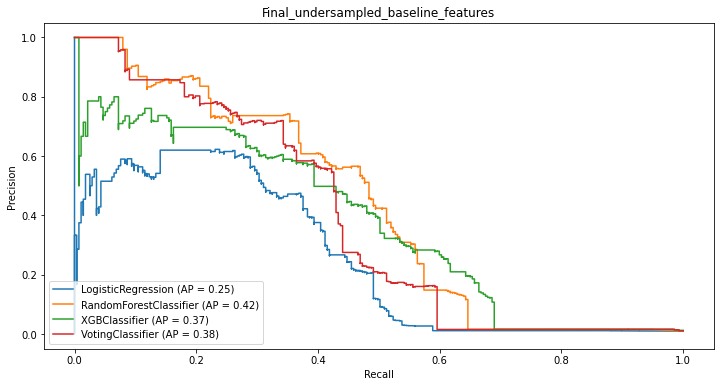

In [43]:
plot_pr_cuves(clf_list, x_test[baseline_features], y_test,title = 'Final_undersampled_baseline_features')

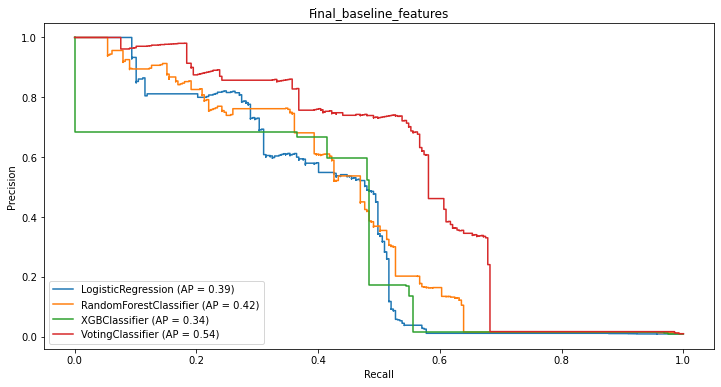

In [69]:
# Baseline features with class ratio - balanced
plot_pr_cuves(clf_list, x_test_scale, y_test,title = 'Final_baseline_features')

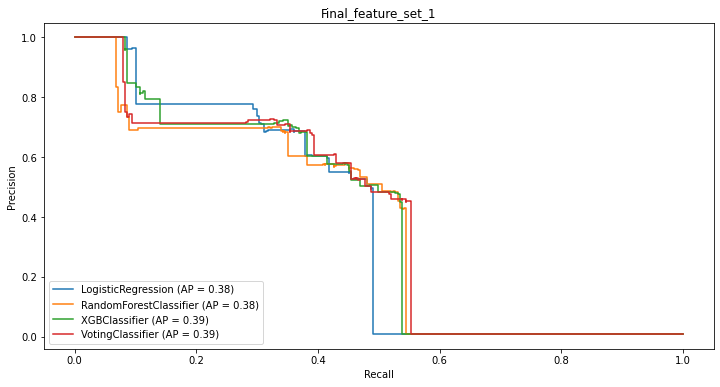

In [92]:
plot_pr_cuves(clf_list, x_test[feature_set_1], y_test,title = 'Final_feature_set_1')

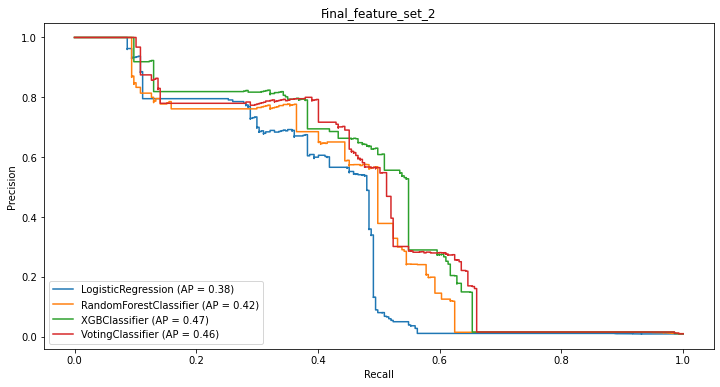

In [98]:
plot_pr_cuves(clf_list, x_test[feature_set_2], y_test,title = 'Final_feature_set_2')

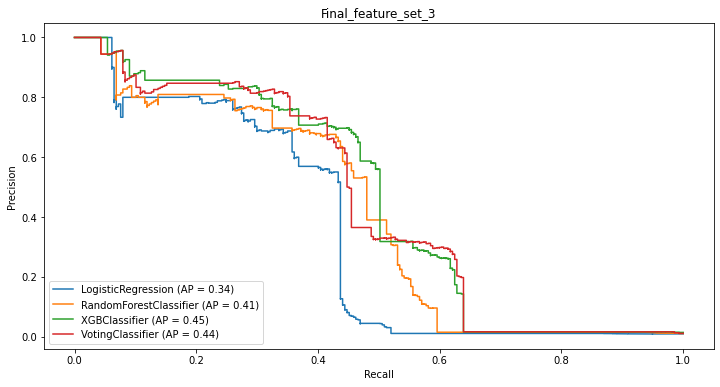

In [103]:
plot_pr_cuves(clf_list, x_test[feature_set_3], y_test,title = 'Final_feature_set_3')

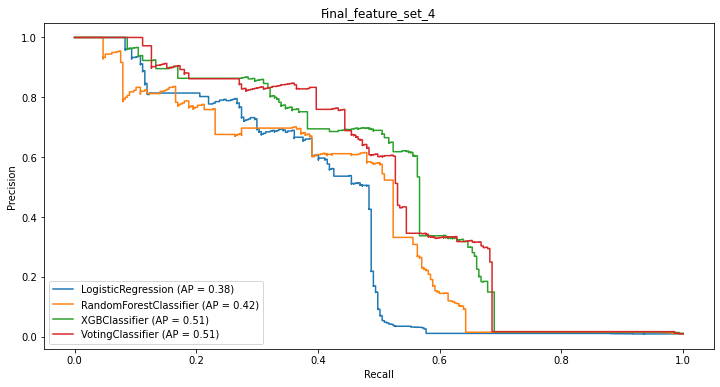

In [108]:
plot_pr_cuves(clf_list, x_test[feature_set_4], y_test,title = 'Final_feature_set_4')

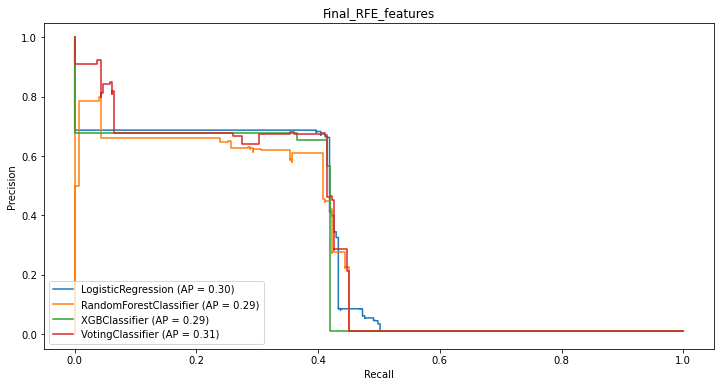

In [74]:
plot_pr_cuves(clf_list, x_test[rfe_feats], y_test,title = 'Final_RFE_features')

### NN with 4 FC layers
Worse performance than tree based methods, loss saturated at a point. Fairly deep network for simple structured data. Overfits very easily after just 3 epochs.

In [78]:
# standardised data to get 0 mean, 1 std
scale = StandardScaler()

featureset = feature_set_4

x_train = train[featureset]
y_train = train['Label']

# One-hot encoded labels
dummy_labels = tf.keras.utils.to_categorical(y_train)

x_test = test[featureset]
y_test = test['Label']

x_train_scale = scale.fit_transform(x_train)
x_test_scale = scale.fit_transform(x_test)
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [79]:
def base_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(27, input_shape=(len(featureset),)))
    # Dropout regularization to prevent overfitting
    model.add(tf.keras.layers.Dropout(rate = 0.4))
    model.add(tf.keras.layers.Dense(27, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(rate = 0.4))
    model.add(tf.keras.layers.Dense(27,  activation = 'relu'))
    model.add(tf.keras.layers.Dropout(rate = 0.4))
    model.add(tf.keras.layers.Dense(2, activation = 'sigmoid'))

# Learning parameters

    model.compile(optimizer = 'adam',
                 loss='binary_crossentropy',
                 metrics = ['accuracy'])
    
    return model

In [80]:
model_ann = base_model()
model_ann.fit(x_train_scale, dummy_labels, batch_size = 32, epochs = 3, class_weight = {0:1, 1:class_weight})

Train on 114706 samples
Epoch 1/3
114706/114706 [==============================] - 17s 147us/sample - loss: 1.1298 - accuracy: 0.9378
Epoch 2/3
114706/114706 [==============================] - 14s 120us/sample - loss: 1.0576 - accuracy: 0.9818
Epoch 3/3
114706/114706 [==============================] - 14s 118us/sample - loss: 1.0158 - accuracy: 0.9834


In [81]:
y_pred = model_ann.predict_classes(x_test_scale)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29343
           1       0.41      0.55      0.47       277

    accuracy                           0.99     29620
   macro avg       0.70      0.77      0.73     29620
weighted avg       0.99      0.99      0.99     29620



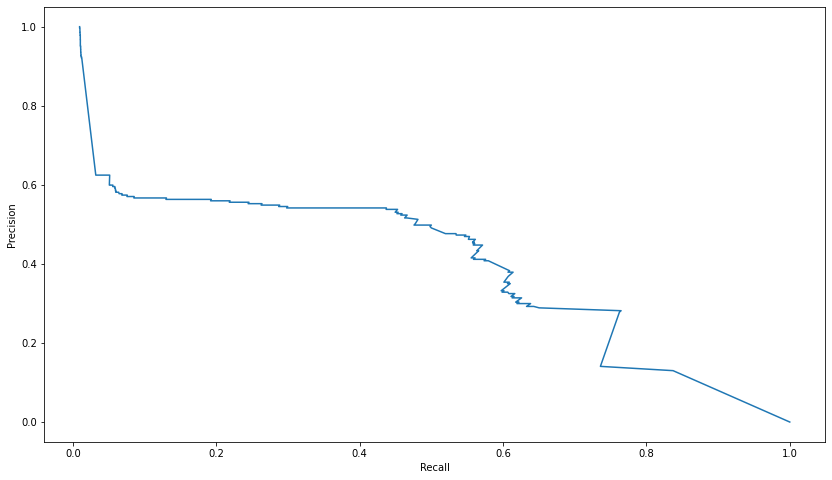

In [113]:
# Plotting precision-Recall on Test Set.
y_pred_proba = model_ann.predict_proba(x_test_scale)
pred_curve = precision_recall_curve(y_test, y_pred_proba[:,1])
plt.plot(pred_curve[0], pred_curve[1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## F. SMOTE - Synthetic Minority Oversampling Technique
Artificially generates minority sample points via a <b> k - nearest neighbour </b> type approach. New instances generated by synthesizing them inbetween features of existing minority samples. Artificially boost the number of minority samples to the around the same as the majority samples. <br>
Worse performance than class_weights = 'balanced'. Better than undersampling, requires tuning of the hypeparameter - ratio: of majority and minority class samples for binary classification. <br>
Important to only uses synthetic points for training, not for validation or test, leakage.

In [135]:
from imblearn.over_sampling import SMOTE

In [136]:
def oversample_train(model, x_train, y_train,x_test,  y_test, resample_ratio = .1, verbose = False):
    """Evaluate F1 Score on both train and test set using different resample ratios."""
    
    # SMOTE uses a nearest neighbour approach to generate samples. Needs data to be normalised.
    sm = SMOTE(sampling_strategy=resample_ratio)  
    x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
    
    if verbose:
        print(f'Original ratio:\n{y_train.value_counts()},\nResampled ratio:\n{y_train_res.value_counts()}')
    
    model.fit(x_train_res, y_train_res)
    train_f1= f1_score(y_train_res, model.predict(x_train_res))
    
    # test set predictions
    y_pred= model.predict(x_test)
    test_f1 = f1_score(y_test, y_pred)
    
    if verbose:
        print(f'\nTrain set F1 Score - {train_f1}') 
        print(f'Test Set F1 Score - {test_f1}')
    
    return train_f1, test_f1

In [137]:
x_train, x_test, y_train, y_test = train_test_split_acc(train, test_size=0.38)
# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)

# Saving baseline feature set and scaling
baseline_features = x_train.columns.to_list()
x_train_scale = scale.fit_transform(x_train)
x_test_scale = scale.transform(x_test)

In [165]:
score = {'train':[], 'test': []}

range_ratio = (0.01,0.1)

for ratio in np.linspace(range_ratio[0],range_ratio[1], 10):
    temp = oversample_train(xgb_clf, x_train_scale, y_train, x_test_scale, y_test, resample_ratio=ratio)
    score['train'].append(temp[0])
    score['test'].append(temp[1])

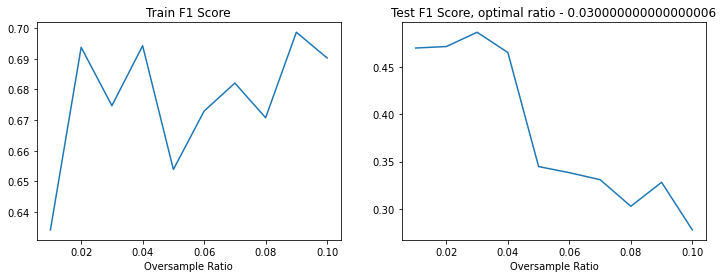

In [166]:
max_ratio = np.linspace(range_ratio[0],range_ratio[1], 10)[np.argmax(np.array(score['test']))]

fig, ax = plt.subplots(1,2, figsize = (12,4))

ax[0].set_title('Train F1 Score')
ax[0].plot(np.linspace(range_ratio[0],range_ratio[1], 10), score['train'])

ax[1].set_title(f'Test F1 Score, optimal ratio - {max_ratio}')
ax[1].plot(np.linspace(range_ratio[0],range_ratio[1], 10), score['test'])
ax[0].set_xlabel('Oversample Ratio')
ax[1].set_xlabel('Oversample Ratio')
plt.show()

In [167]:
sm = SMOTE(sampling_strategy = max_ratio)

# SMOTE uses a nearest neighbour approach to generate samples. Needs data to be normalised.

x_train_res, y_train_res = sm.fit_sample(x_train_scale, y_train)

# Not given weightage to classes/gradients

clf_log = LogisticRegression(solver='sag', n_jobs=-1)

clf_rf = RandomForestClassifier(n_estimators=150, criterion='gini',
                                max_depth=6, n_jobs=-1)

xgb_clf = XGBClassifier(eta = .3, max_depth = 6,
                        n_estimators = 100,
                        objective='binary:logistic',  eval_metric = 'aucpr',
                       tree_method='gpu_hist')

# saving list of classifiers 
clf_list = [clf_log, clf_rf, xgb_clf]

clf_log.fit(np.array(x_train_res), y_train_res)
clf_rf.fit(np.array(x_train_res), y_train_res)
xgb_clf.fit(np.array(x_train_res), y_train_res,
             verbose=True)

print(f'Logistic Regression - {f1_score(y_train_res, clf_log.predict(np.array(x_train_res)))}')
print(f'Random Forest - {f1_score(y_train_res, clf_rf.predict(np.array(x_train_res)))}')
print(f'XGBoost - {f1_score(y_train_res, xgb_clf.predict(np.array(x_train_res)))}')

Logistic Regression - 0.4515393386545041
Random Forest - 0.567719298245614
XGBoost - 0.7458244761615548


In [168]:
y_pred_log = clf_log.predict(np.array(x_test_scale))
y_pred_rf = clf_rf.predict(np.array(x_test_scale))
y_pred_xgb = xgb_clf.predict(np.array(x_test_scale))

print('Logistic Regression\n', f1_score(y_test, y_pred_log))
print('RandomForestClassifier\n', f1_score(y_test, y_pred_rf))
print('XGBClassifier\n',f1_score(y_test, y_pred_xgb))

Logistic Regression
 0.3525535420098847
RandomForestClassifier
 0.42878560719640174
XGBClassifier
 0.43809523809523815


In [169]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     47134
         1.0       0.56      0.36      0.44       448

    accuracy                           0.99     47582
   macro avg       0.78      0.68      0.72     47582
weighted avg       0.99      0.99      0.99     47582



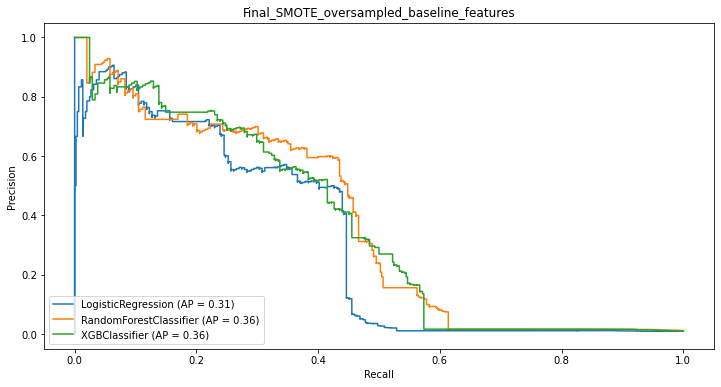

In [170]:
plot_pr_cuves(clf_list, x_test_scale, y_test,title = 'Final_SMOTE_oversampled_baseline_features')

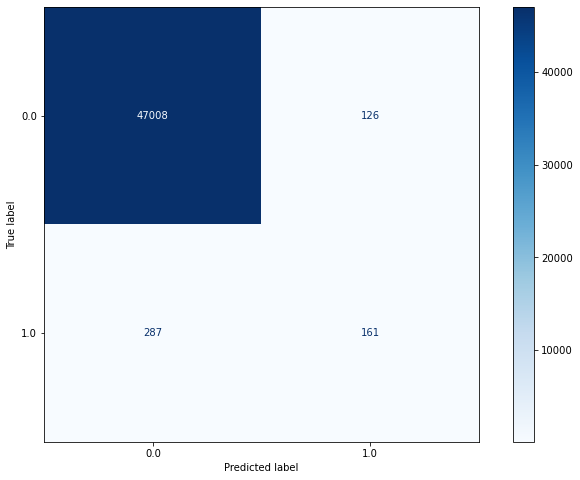

In [171]:
plot_confusion_matrix(xgb_clf, x_test_scale, y_test, cmap=plt.cm.Blues)

In [173]:
def group_cv_smote(model, train, labels, folds, ret_scores= False, class_weights=True, ratio=0.1):
    """Groups must be AccountId index"""
    scores = {'f1_score': [], 'pos_pr': [],
              'pos_rc': [], 'pos_f1': []}

    for train_idx, test_idx in folds.split(train,labels, groups=train.index):
        print(train.iloc[train_idx].shape, train.iloc[test_idx].shape)
        # sanity check 
        #overlap_sanity_check(train.iloc[train_idx], train.iloc[test_idx])

        x_train = train.iloc[train_idx]
        x_test = train.iloc[test_idx]
        
        y_train = labels.iloc[train_idx]
        y_test = labels.iloc[test_idx]
        
        # normalisation needed for SMOTE
        scale = MinMaxScaler()
        x_train = scale.fit_transform(np.array(x_train))
        x_test = scale.transform(np.array(x_test))
        
        # Oversample Train set 
        sm = SMOTE(sampling_strategy = max_ratio)

        x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

        # Calculating Class Weights.
        model.scale_pos_weight = 1
        if class_weights:
            class_weight = y_train_res.value_counts()[0]/y_train_res.value_counts()[1]
            model.scale_pos_weight = np.sqrt(class_weight)
        
        model.fit(x_train_res, y_train_res)
        
        preds = model.predict(x_test)
        
        pos_metrics = precision_recall_fscore_support(y_test, preds)
        
        scores['f1_score'].append(f1_score(y_test, preds))       
        scores['pos_pr'].append(pos_metrics[0][1])
        scores['pos_rc'].append(pos_metrics[1][1])
        scores['pos_f1'].append(pos_metrics[2][1])
        
    # score summary
    summary = ((np.mean(np.array(scores['pos_pr'])), np.std(np.array(scores['pos_pr']))),
               (np.mean(np.array(scores['pos_rc'])), np.std(np.array(scores['pos_rc']))),
              (np.mean(np.array(scores['f1_score'])), np.std(np.array(scores['f1_score']))))
    
    if ret_scores:
        return scores
    else:
        return summary

In [175]:
group_cv_smote(xgb_clf, train[baseline_features], train['Label'], folds, ratio=max_ratio, class_weights=False)

(91764, 62) (22942, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)
(91765, 62) (22941, 62)


((0.6529950935860196, 0.032003069571291586),
 (0.4162236668918813, 0.025437735691061773),
 (0.5075387637605203, 0.019204631128696272))

## G. Isolation Forest
Unsupervised approach where we build multiple trees with the goal of isolating the observations in their leaves. Ideally, each leaf of the tree isolates exactly one observation from your data set. The trees are being split randomly. We assume that if one observation is similar to others in our dataset, it will take more random splits to perfectly isolate this observation, as opposed to isolating an outlier. For an outlier that has some feature values significantly different from the other observations, randomly finding the split isolating it should not be too hard. As we build multiple isolation trees, hence the isolation forest, for each observation we can calculate the average number of splits across all the trees that isolate the observation. The average number of splits is then used as a score, where the less splits the observation needs, the more likely it is to be anomalous.

In [182]:
# It is known that the contamination is 0.009381, not sure if its reasonable to assume that'll always be the case.
# Trying auto
isforest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto',
                max_features=1.0, bootstrap=False, n_jobs=-1,
                behaviour='deprecated', random_state=None, verbose=1, warm_start=False)

In [212]:
x_train, x_test, y_train, y_test = train_test_split_acc(train, test_size=0.38)
# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)

# Saving baseline feature set and scaling
scale = MinMaxScaler()

x_train_scale = scale.fit_transform(x_train[feature_set_1].values)
x_test_scale = scale.transform(x_test[feature_set_1].values)

In [213]:
#featureset = feature_set_1
isforest.fit(x_train_scale)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


IsolationForest(n_jobs=-1, verbose=1)

In [214]:
res = isforest.predict(x_test_scale)
res_score = isforest.score_samples(x_test_scale)
np.unique(res, return_counts=True)

(array([-1,  1]), array([  724, 46858]))

In [215]:
iso_for = pd.DataFrame({'preds' : res,
                          'actual' : y_test,
                          'scores' : -res_score})
iso_for.preds.replace(to_replace=1, value = 0, inplace=True)
iso_for.preds.replace(to_replace=-1, value = 1, inplace=True)
iso_for.preds.value_counts()

0    46858
1      724
Name: preds, dtype: int64

In [216]:
print(classification_report(iso_for.actual, iso_for.preds))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     47134
         1.0       0.29      0.46      0.35       448

    accuracy                           0.98     47582
   macro avg       0.64      0.73      0.67     47582
weighted avg       0.99      0.98      0.99     47582



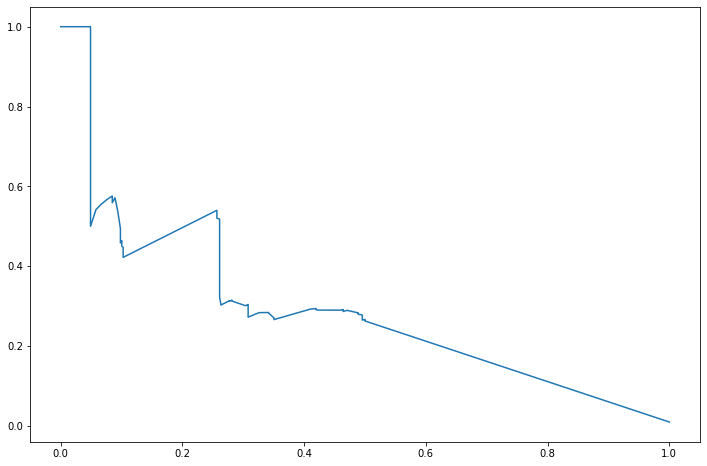

In [217]:
precision, recall, aucpr_score = precision_recall_curve(iso_for.actual, iso_for.scores)
plt.plot(recall, precision)

# 2. Time-Series Approach - Exploring overall Time-Series and by Account ID.
1. The data can be though of as 62 simultaneous time-series, for each feature,for each account. 
2. The time-series are different lengths, makes sense for different customers joining/leaving at different times. Is a problem, looking at a single account first and also how the label acts over all accounts over time.
3. Plot the number of positive labels for the time series, overlay with the number of unique accounts then. See if spike, seasonality etc. (Done)
4. Plot the time series for featuresets from above. (Done)

#### Overall Time-Series : Number of Accounts and Interventions over time
1. There doesn't appear to be any relationship between the growth in the number of accounts, and the number of interventions. One problem is that the cumulative sum includes duplicate accounts. Plotting the change in accounts seems to show a relationship between the two. Statistically significant, strong linear relationship according to pearsons correlation coefficient.
2. Bi-yearly seasonality looks to be present in the number of interventions required.

In [22]:
# Reloading, cannot index by account id, groupby isn't working as expected.
train = pd.read_csv('Train_Set.csv')
test = pd.read_csv('Test_Set.csv')

temp = train.copy()

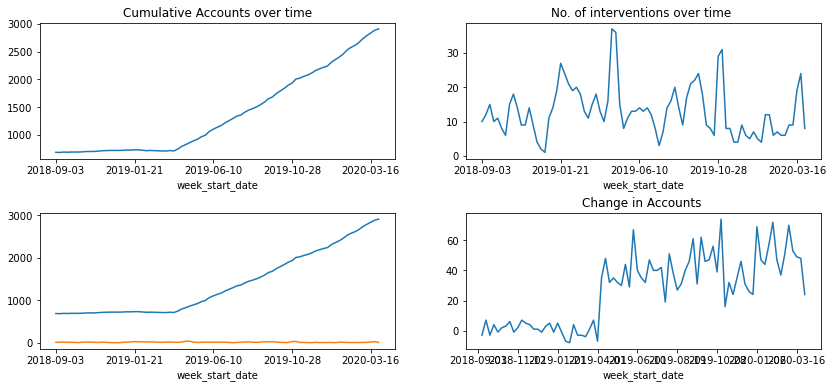

In [23]:
fig, ax = plt.subplots(2, 2, figsize = (14, 6))

plt.subplots_adjust(hspace = 0.4)
train.groupby(['week_start_date'])['account_id'].count().plot(kind = 'line', ax = ax[0,0])
ax[0,0].set_title('Cumulative Accounts over time')
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[0,1])
ax[0,1].set_title('No. of interventions over time ')
train.groupby(['week_start_date'])['account_id'].count().plot(kind = 'line', ax = ax[1,0])
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[1,0])
change = (temp.groupby(['week_start_date'])['account_id'].count() - 
          temp.groupby(['week_start_date'])['account_id'].count().shift(1))
change.plot(kind = 'line', ax = ax[1,1])
ax[1,1].set_title('Change in Accounts ')

plt.show()

In [24]:
pearsonr(train.groupby(['week_start_date'])['account_id'].count()[1:].values, change.values[1:])

(0.7077372820234344, 1.0515141605376794e-13)

Comparing the trend and any spike in positive labels, and the sum of the values of the features, there doesn't seem to be much correlation except for what was seen in the correlation heatmap.

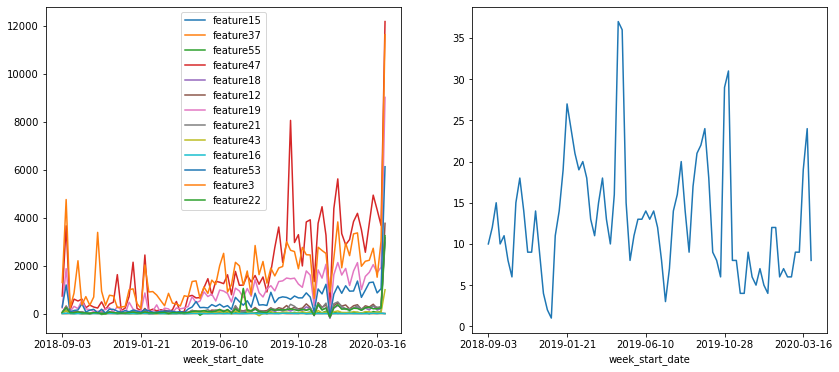

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

for item in feature_set_4:
    train.groupby(['week_start_date'])[item].sum().plot(legend = True, ax = ax[0])
    
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[1])
plt.show()

#### Account Wise Time-Series

In [26]:
# Accounts with most data points.
train['account_id'].value_counts()

104959.0    280
105810.0    278
109056.0    278
100618.0    274
102171.0    272
           ... 
100796.0      1
187594.0      1
101642.0      1
239954.0      1
239955.0      1
Name: account_id, Length: 2690, dtype: int64

Difficult to pin-point any obvious relationship between a features value and the label just by looking at the data. 

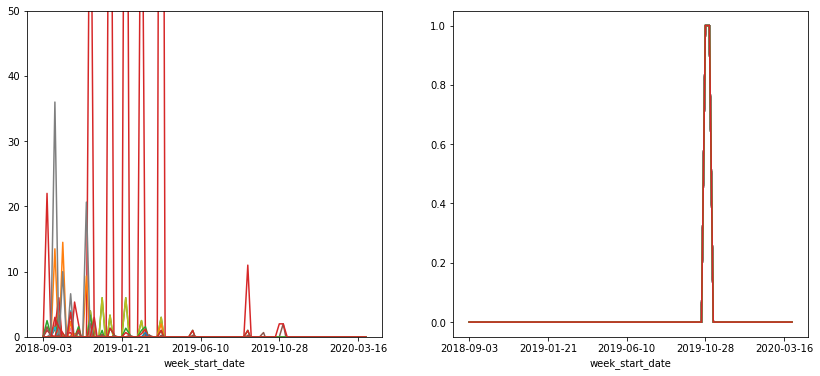

In [27]:
temp = train.loc[train['account_id'] == 104959.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in temp.drop(['week_start_date'],axis = 1).columns:
    temp.groupby(['week_start_date'])[item].sum().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

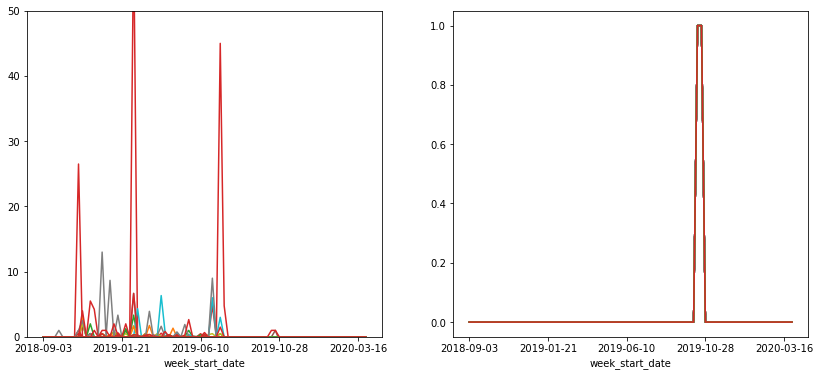

In [28]:
temp = train.loc[train['account_id'] == 105810.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in temp.drop(['week_start_date'],axis = 1).columns:
    temp.groupby(['week_start_date'])[item].max().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

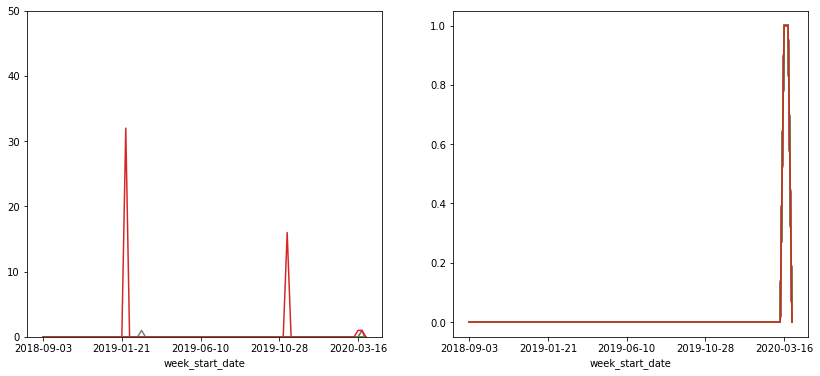

In [29]:
temp = train.loc[train['account_id'] == 109056.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in temp.drop(['week_start_date'],axis = 1).columns:
    temp.groupby(['week_start_date'])[item].max().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

#### Looking at a single account 
Feature interaction with label.

In [30]:
single_feat_acc = temp[['week_start_date', 'feature15', 'Label']]
single_feat_acc.describe()

,feature15,Label
count,278.000000,278.000000
mean,0.003597,0.014388
std,0.094933,0.119301
min,-0.500000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


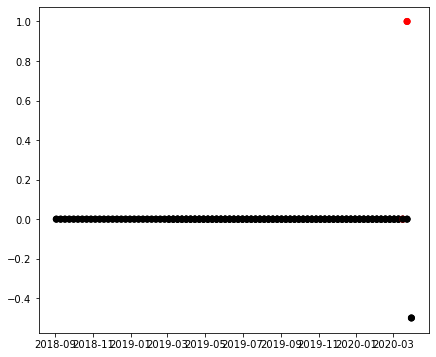

In [31]:
single_feat_acc['week_start_date'] = pd.to_datetime(single_feat_acc['week_start_date'])

# externally mapping colors 
plt.figure(figsize=(7,6))
c = single_feat_acc.Label.values
colors = np.array(["black", "red"])
plt.scatter(single_feat_acc['week_start_date'], single_feat_acc['feature15'], c=colors[c])
plt.show()

#### Grouping accounts and observing time-series with labels.
Accounts by duration of usage. interventions required after ~80 entries and ~160 entries. Some plan or Usage scheme expires ?

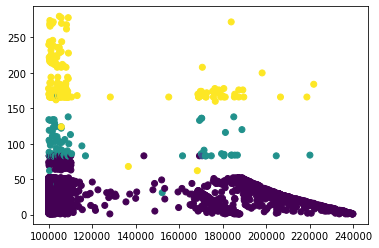

In [32]:
plt.scatter(train.groupby(['account_id'])['week_start_date'].count().index,
         y = train.groupby(['account_id'])['week_start_date'].count().values,
         c = train.groupby(['account_id'])['Label'].sum().values)
plt.show()

#### Modifying Week start column to Reflect days since first record of account.
1. convert week start date to date time
2. create new column with 0 values
3. filter DF by for each account
3. calculate the days since start for filtered df and replace empty column

In [33]:
train['week_start_date'] = pd.to_datetime(train['week_start_date'])
# same for test set.
test['week_start_date'] = pd.to_datetime(test['week_start_date'])

##### Extracting Date-Time features. 
Days since first record of account.(very time consuming)

In [81]:
train['days_since_first_week'] = 0
for account in train.account_id.unique():
    temp = train.loc[(train.account_id == account)]
    first_week = temp['week_start_date'].min()
    temp['days_since_first_week'] = temp['week_start_date'].apply(lambda x : x - first_week)
    temp.days_since_first_week = temp.days_since_first_week.dt.days
    train.loc[(train.account_id == account), 'days_since_first_week'] = temp.days_since_first_week

AttributeError: 'DataFrame' object has no attribute 'account_id'

In [35]:
# Same for external test set for final performance measure later

test['days_since_first_week'] = 0
for account in test.account_id.unique():
    temp = test.loc[(test.account_id == account)]
    first_week = temp['week_start_date'].min()
    temp['days_since_first_week'] = temp['week_start_date'].apply(lambda x : x - first_week)
    temp.days_since_first_week = temp.days_since_first_week.dt.days
    test.loc[(test.account_id == account), 'days_since_first_week'] = temp.days_since_first_week

In [36]:
# date time features. Not much of a performance improvement.

def create_date_feats(feats):
    feats['day_month'] = feats.week_start_date.dt.day
    feats['month'] = feats.week_start_date.dt.month
    feats['day_week'] = feats.week_start_date.dt.dayofweek
    feats['quarter'] = feats.week_start_date.dt.quarter
    feats['week_year'] = feats.week_start_date.dt.weekofyear
    feats['day_year'] = feats.week_start_date.dt.dayofyear
    return feats

In [37]:
train = create_date_feats(train)
test = create_date_feats(test)

/home/desktop-anand/.conda/envs/DS/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [38]:
train.drop(['week_start_date'], axis=1, inplace = True)
test.drop(['week_start_date'], axis=1, inplace = True)

In [39]:
train.set_index('account_id', inplace=True)
test.set_index('account_id', inplace=True)

In [40]:
folds = GroupKFold(n_splits=5)

In [66]:
date_feats = ['days_since_first_week', 'day_month', 'month',
       'day_week', 'quarter', 'week_year', 'day_year']

In [72]:
group_cv_xgb(xgb_clf, train.drop(['Label'], axis=1), train['Label'], folds, class_weights=True,early_stopping=True)

(91764, 69) (22942, 69)
(91765, 69) (22941, 69)
(91765, 69) (22941, 69)
(91765, 69) (22941, 69)
(91765, 69) (22941, 69)


((0.6019582479139313, 0.06619586371539371),
 (0.4405634211670514, 0.020138280591902615),
 (0.5073563304336495, 0.031320341527831926),
 (14.6, 8.309031231136395))

In [73]:
group_cv_xgb(xgb_clf, train[feature_set_1 + date_feats], train['Label'], folds, class_weights=True,early_stopping=True)

(91764, 10) (22942, 10)
(91765, 10) (22941, 10)
(91765, 10) (22941, 10)
(91765, 10) (22941, 10)
(91765, 10) (22941, 10)


((0.5945371171597704, 0.05106974017955388),
 (0.45425697711219026, 0.019609930587751238),
 (0.5136851386950837, 0.020057119216136975),
 (13.0, 7.6681158050723255))

In [75]:
group_cv_xgb(xgb_clf, train[feature_set_2 + date_feats], train['Label'], folds, class_weights=True,early_stopping=True)

(91764, 14) (22942, 14)
(91765, 14) (22941, 14)
(91765, 14) (22941, 14)
(91765, 14) (22941, 14)
(91765, 14) (22941, 14)


((0.5986697845862061, 0.04688675816713194),
 (0.44979331927960037, 0.018971216345305405),
 (0.5131322011568269, 0.02588014262469967),
 (17.0, 4.049691346263317))

In [76]:
group_cv_xgb(xgb_clf, train[feature_set_3 + date_feats], train['Label'], folds, class_weights=True,early_stopping=True)

(91764, 13) (22942, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)
(91765, 13) (22941, 13)


((0.5344931831778693, 0.07799730182119397),
 (0.43954261775494363, 0.030515881777822832),
 (0.47934298008618115, 0.03406059243847711),
 (11.6, 8.309031231136396))

In [77]:
group_cv_xgb(xgb_clf, train[feature_set_4 + date_feats], train['Label'], folds, class_weights=True,early_stopping=True)

(91764, 20) (22942, 20)
(91765, 20) (22941, 20)
(91765, 20) (22941, 20)
(91765, 20) (22941, 20)
(91765, 20) (22941, 20)


((0.5888480083007824, 0.04179124965105476),
 (0.44684823067051854, 0.018048479033086037),
 (0.5073084342860164, 0.019024922371000938),
 (16.6, 7.812809993849845))

In [78]:
x_train, x_test, y_train, y_test = train_test_split_acc(train, test_size=0.38)

In [79]:
# Calculating Class Weights.
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [80]:
# Dropping time-series week start markers. 
#x_train.drop(['week_start_date'], axis = 1, inplace=True)
#x_test.drop(['week_start_date'], axis = 1, inplace=True)

In [82]:
xgb_clf = XGBClassifier(scale_pos_weight = 1, max_depth = 6,
                        n_estimators = 100,
                        objective='binary:logistic', learning_rate = .2, eval_metric = 'aucpr',
                        tree_method='gpu_hist')

# early stopping on validation set is leakage.

xgb_clf.fit(np.array(x_train), y_train, 
             #early_stopping_rounds=5, 
             #eval_set=[(np.array(x_test), y_test)],
             verbose=True)

print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train)))}')

XGBoost - 0.7328094302554028


In [83]:
y_pred_xgb = xgb_clf.predict(np.array(x_test))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

XGBClassifier
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47134
           1       0.64      0.34      0.45       448

    accuracy                           0.99     47582
   macro avg       0.82      0.67      0.72     47582
weighted avg       0.99      0.99      0.99     47582



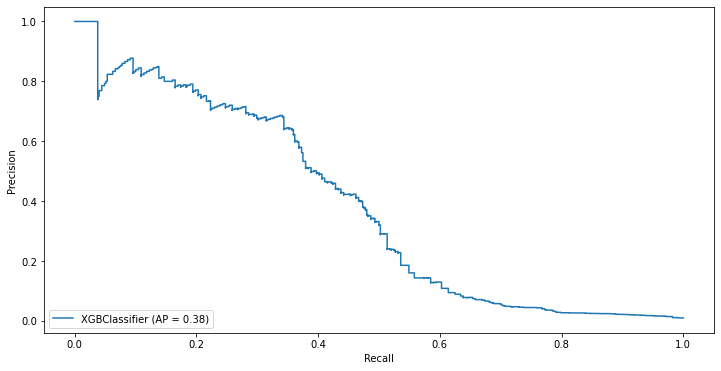

In [84]:
plot_pr_cuves([xgb_clf], np.array(x_test), y_test, '')

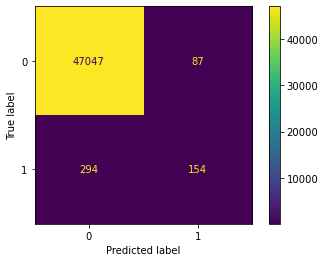

In [85]:
plot_confusion_matrix(xgb_clf, np.array(x_test), y_test)

In [89]:
xgb_trx = return_threshold(xgb_clf, x_train, y_train)

y_pred_xgb = preds_threhold(xgb_clf, xgb_trx, x_test)

print('XGboost\n', classification_report(y_test, y_pred_xgb))

0.32920107
XGboost
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47134
           1       0.60      0.37      0.46       448

    accuracy                           0.99     47582
   macro avg       0.80      0.68      0.73     47582
weighted avg       0.99      0.99      0.99     47582



In [90]:
print(confusion_matrix(y_test, y_pred_xgb))

[[47023   111]
 [  283   165]]


### CatBoost

In [92]:
from catboost import CatBoostClassifier, Pool, cv

# preparing pool of features and categorical features(None) for catboost 
train_pool = Pool(x_train, y_train, cat_features=None)

cat_clf = CatBoostClassifier(iterations=1000,
                        learning_rate=.1, loss_function='Logloss', eval_metric='F1',
                             class_weights={0:1, 1:class_weight})

In [93]:
cat_clf.fit(train_pool,
    eval_set=(x_test, y_test),
     #logging_level='Verbose', 
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6321278	test: 0.5760679	best: 0.5760679 (0)	total: 78ms	remaining: 1m 17s
1:	learn: 0.6444268	test: 0.5859264	best: 0.5859264 (1)	total: 93ms	remaining: 46.4s
2:	learn: 0.6879107	test: 0.6144431	best: 0.6144431 (2)	total: 107ms	remaining: 35.7s
3:	learn: 0.6967823	test: 0.6130184	best: 0.6144431 (2)	total: 122ms	remaining: 30.4s
4:	learn: 0.6992117	test: 0.6150824	best: 0.6150824 (4)	total: 137ms	remaining: 27.2s
5:	learn: 0.7181733	test: 0.6307579	best: 0.6307579 (5)	total: 151ms	remaining: 25s
6:	learn: 0.7211600	test: 0.6355912	best: 0.6355912 (6)	total: 166ms	remaining: 23.6s
7:	learn: 0.7334211	test: 0.6432526	best: 0.6432526 (7)	total: 181ms	remaining: 22.4s
8:	learn: 0.7359264	test: 0.6472451	best: 0.6472451 (8)	total: 196ms	remaining: 21.6s
9:	learn: 0.7350180	test: 0.6434890	best: 0.6472451 (8)	total: 211ms	remaining: 20.9s
10:	learn: 0.7442226	test: 0.6569361	best: 0.6569361 (10)	total: 225ms	remaining: 20.3s
11:	learn: 0.7457218	test: 0.6570095	best: 0.6570095 (1

In [233]:
# Catboost seems to be using a different form of f1 averaging than sklearn models. Much higher. 
cat_clf.best_score_

{'learn': {'Logloss': 0.2429604664826778, 'F1': 0.8619832047532711},
 'validation': {'Logloss': 0.4639165721037999, 'F1': 0.7119555277287287}}

In [234]:
y_pred_catb = cat_clf.predict(x_test)
print('CatBoostClassifier\n',classification_report(y_test, y_pred_catb))

CatBoostClassifier
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     47134
           1       0.10      0.58      0.17       448

    accuracy                           0.95     47582
   macro avg       0.55      0.77      0.57     47582
weighted avg       0.99      0.95      0.96     47582



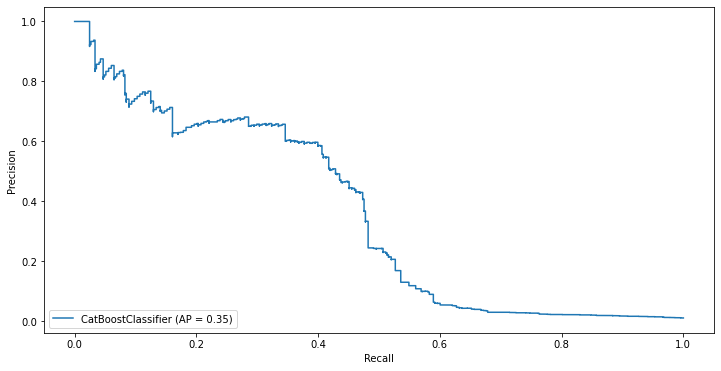

In [235]:
plot_pr_cuves([cat_clf], x_test, y_test, '')

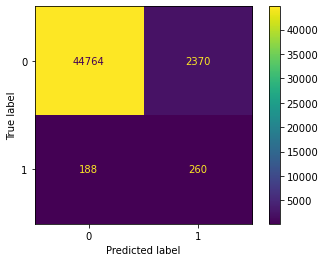

In [236]:
# Slightly better than XGBoost 
plot_confusion_matrix(cat_clf, x_test, y_test)

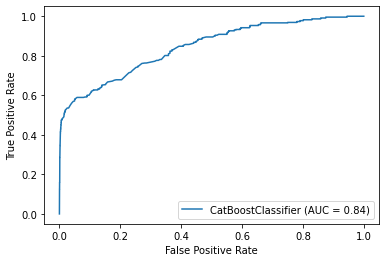

In [237]:
plot_roc_curve(cat_clf, x_test, y_test)

In [238]:
cat_clf_probs = cat_clf.predict_proba(x_test)

# only keeping the positive class 

cat_clf_probs = cat_clf_probs[:,1]

In [239]:
precision, recall, thresholds = precision_recall_curve(y_test, cat_clf_probs)

In [240]:
# manually calculate the F1 score and find the index of argmax of F1 score. 
# use that index to find max threshold.

f_score = (2 * precision * recall) / (precision + recall)

ix = np.argmax(f_score)
threshold = thresholds[ix]
threshold

0.9187095673423891

In [241]:
# using this threshold to get labels from XGB
y_pred_cat_opt = (cat_clf_probs >=threshold).astype('int')

# optimal threshold metrics

print(classification_report(y_test, y_pred_cat_opt))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47134
           1       0.59      0.41      0.48       448

    accuracy                           0.99     47582
   macro avg       0.79      0.70      0.74     47582
weighted avg       0.99      0.99      0.99     47582



In [242]:
print(confusion_matrix(y_test, y_pred_cat_opt))

[[47005   129]
 [  266   182]]


### Final test set Evaluation
Training catBoost for 200 iterations going by train, validation performance.

In [244]:
cat_clf = CatBoostClassifier(iterations=200,
                        learning_rate=.1, loss_function='Logloss', eval_metric='F1',
                             class_weights={0:1, 1:class_weight})

cat_clf.fit(train.drop(['Label'], axis =1),train['Label'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6421557	total: 21.1ms	remaining: 4.2s
1:	learn: 0.6865995	total: 43.1ms	remaining: 4.27s
2:	learn: 0.7011042	total: 65ms	remaining: 4.27s
3:	learn: 0.6972179	total: 86.3ms	remaining: 4.23s
4:	learn: 0.7040190	total: 109ms	remaining: 4.23s
5:	learn: 0.7064420	total: 130ms	remaining: 4.2s
6:	learn: 0.7110851	total: 151ms	remaining: 4.17s
7:	learn: 0.7089402	total: 173ms	remaining: 4.16s
8:	learn: 0.7135554	total: 196ms	remaining: 4.15s
9:	learn: 0.7082199	total: 217ms	remaining: 4.12s
10:	learn: 0.7217418	total: 238ms	remaining: 4.09s
11:	learn: 0.7224049	total: 259ms	remaining: 4.07s
12:	learn: 0.7268052	total: 280ms	remaining: 4.02s
13:	learn: 0.7294431	total: 301ms	remaining: 4s
14:	learn: 0.7360839	total: 322ms	remaining: 3.97s
15:	learn: 0.7369130	total: 342ms	remaining: 3.93s
16:	learn: 0.7375017	total: 361ms	remaining: 3.89s
17:	learn: 0.7375496	total: 383ms	remaining: 3.87s
18:	learn: 0.7390120	total: 405ms	remaining: 3.85s
19:	learn: 0.7397420	total: 425ms	remaining:

In [94]:
xgb_clf = XGBClassifier(scale_pos_weight = 1, max_depth = 6,
                        n_estimators = 100,
                        objective='binary:logistic', learning_rate = .2, eval_metric = 'aucpr')

xgb_clf.fit(train.drop(['Label'], axis =1),train['Label'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [95]:
# Final predictions on Test set using the optimal thresholds from training

catboost_preds = cat_clf.predict(test.drop(['Label'], axis =1))

In [96]:
xgb_preds = xgb_clf.predict(test.drop(['Label'], axis =1))

In [97]:
print(classification_report(test['Label'], catboost_preds))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     29343
           1       0.12      0.69      0.20       277

    accuracy                           0.95     29620
   macro avg       0.56      0.82      0.59     29620
weighted avg       0.99      0.95      0.97     29620



In [98]:
print(classification_report(test['Label'], xgb_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29343
           1       0.85      0.50      0.63       277

    accuracy                           0.99     29620
   macro avg       0.92      0.75      0.81     29620
weighted avg       0.99      0.99      0.99     29620



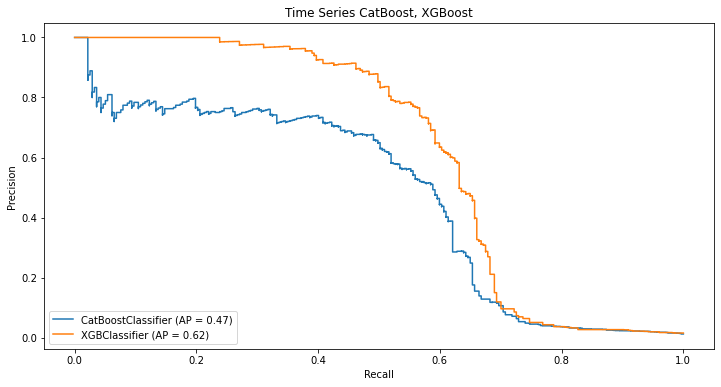

In [99]:
plot_pr_cuves([cat_clf, xgb_clf], test.drop(['Label'], axis =1), test['Label'], 'Time Series CatBoost, XGBoost')

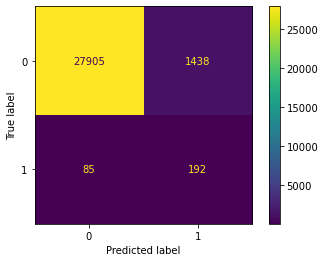

In [100]:
plot_confusion_matrix(cat_clf, test.drop(['Label'], axis =1), test['Label'])

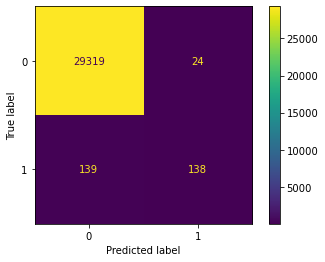

In [101]:
plot_confusion_matrix(xgb_clf, test.drop(['Label'], axis =1), test['Label'])

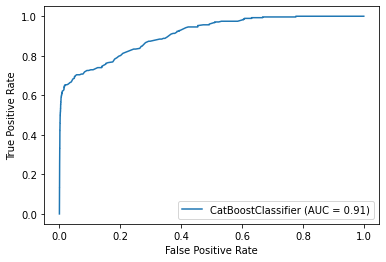

In [102]:
plot_roc_curve(cat_clf, test.drop(['Label'], axis =1), test['Label'])

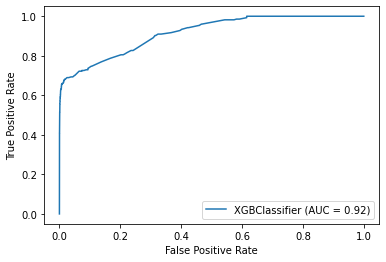

In [103]:
plot_roc_curve(xgb_clf, test.drop(['Label'], axis =1), test['Label'])

## Idea[Leakage, first split into train and test then do the dropping] : 
Keep only the instances where the label changes and a couple of records either way of them. Performs worse than the approach I've been using upto this point. 
1. Look at feature importance. 
2. When keeping records each entry apart from the true label, some duplicate records - removed (keeping them gives better validation performance but much worse test set AUPR And ROC AUC although recall is slightly higher). 

In [163]:
# Reloading, cannot index by account id, groupby isn't working as expected.
train = pd.read_csv('Train_Set.csv')
test = pd.read_csv('Test_Set.csv')

temp = train.copy()

train.reset_index(inplace=True)

In [164]:
index_true = train.index[train.Label == 1]

In [165]:
new_index = index_true.append(index_true + 1).append(index_true - 1)

In [166]:
# think about removing duplicate index items here 
new_index = new_index.drop_duplicates()

In [167]:
new_train = train.loc[new_index]

In [168]:
new_train = new_train.set_index('account_id')
new_train.drop(['index'], axis = 1 , inplace = True)

In [171]:
x_train, x_test, y_train, y_test = train_test_split_acc(new_train)
#### Sanity check 
overlap_sanity_check(x_train, x_test)

In [172]:
# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)

In [15]:
folds = GroupKFold(n_splits=5)

In [177]:
# This wouldn't work. undersample by label before CV.
group_cv(xgb_clf, new_train.drop(['Label', 'week_start_date'], axis = 1), new_train['Label'], folds, normalise=True,
         class_weights=False)

(1966, 62) (494, 62)
(1967, 62) (493, 62)
(1969, 62) (491, 62)
(1969, 62) (491, 62)
(1969, 62) (491, 62)


((0.8438695433923759, 0.0211029036467886),
 (0.6261906122876715, 0.05101629583271401),
 (0.7173197348364948, 0.031468178950982265))

In [178]:
xgb_clf = XGBClassifier( max_depth = 6,
                        n_estimators = 100,
                        objective='binary:logistic', learning_rate = .2, eval_metric = 'aucpr',
                       tree_method='gpu_hist')

xgb_clf.fit(np.array(x_train), y_train, 
             #early_stopping_rounds=10, 
             #eval_set=[(np.array(x_test), y_test)],
             verbose=True)

print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train)))}')

XGBoost - 0.8003502626970228


In [182]:
xgb_trx = return_threshold(xgb_clf, x_train, y_train)

y_pred_xgb = preds_threhold(xgb_clf, xgb_trx, x_test)

print('XGboost\n', classification_report(y_test, y_pred_xgb))

0.56291544
XGboost
               precision    recall  f1-score   support

           0       0.75      0.88      0.81       552
           1       0.80      0.61      0.70       418

    accuracy                           0.77       970
   macro avg       0.78      0.75      0.75       970
weighted avg       0.77      0.77      0.76       970



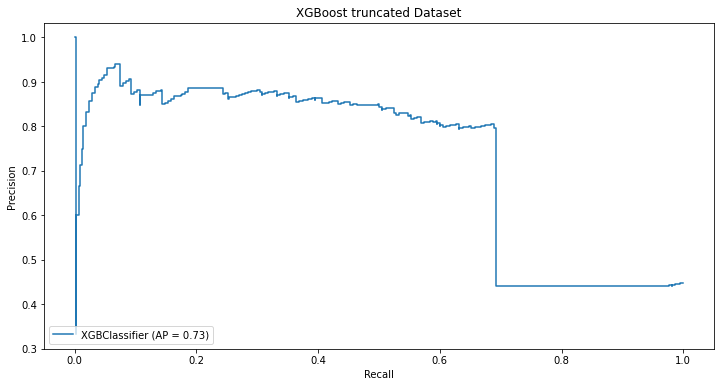

In [184]:
plot_pr_cuves([xgb_clf], np.array(x_test), y_test, 'XGBoost truncated Dataset')

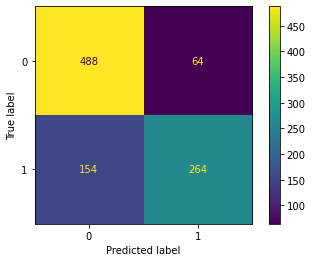

In [188]:
plot_confusion_matrix(xgb_clf, np.array(x_test), y_test)

In [186]:
confusion_matrix(y_test, y_pred_xgb)

array([[488,  64],
       [161, 257]])

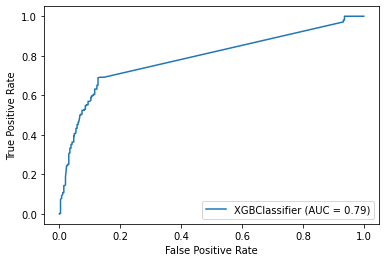

In [189]:
plot_roc_curve(xgb_clf, np.array(x_test), y_test)

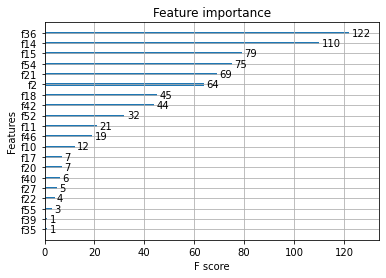

In [190]:
plot_importance(xgb_clf)

In [194]:
# Predicting on final test set 
xgb_preds = xgb_clf.predict(np.array(test.drop(['week_start_date', 'Label','account_id'], axis =1)))

In [195]:
print(classification_report(test['Label'], xgb_preds))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     29343
           1       0.02      0.68      0.04       277

    accuracy                           0.67     29620
   macro avg       0.51      0.67      0.42     29620
weighted avg       0.99      0.67      0.79     29620



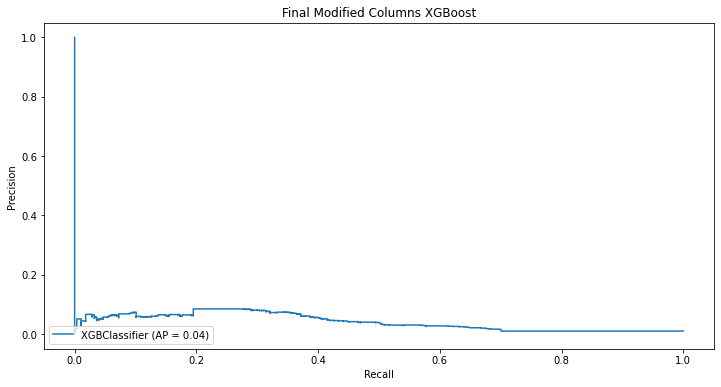

In [197]:
plot_pr_cuves( [xgb_clf], np.array(test.drop(['week_start_date', 'Label', 'account_id'], axis =1)), test['Label'], 'Final Modified Columns XGBoost')

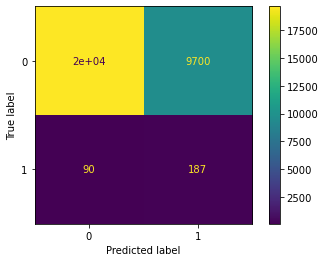

In [199]:
plot_confusion_matrix(xgb_clf, np.array(test.drop(['week_start_date', 'Label','account_id'], axis =1)), test['Label'])

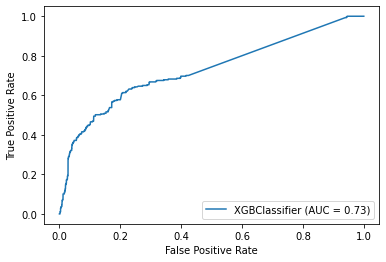

In [200]:
plot_roc_curve(xgb_clf, np.array(test.drop(['week_start_date', 'Label','account_id'], axis =1)), test['Label'])